## **Mount google drive**
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to be current folder
import os
os.chdir('/content/drive/MyDrive/coviddata')
!ls

Mounted at /content/drive
 2020VAERSDATA.csv
 2020VAERSSYMPTOMS.csv
 2020VAERSVAX.csv
 2021VAERSDATA.csv
 2021VAERSSYMPTOMS.csv
 2021VAERSVAX.csv
 BERT_pr.PNG
 BERT_roc_multi.PNG
 BERT_roc.png
 bert_symptom_weights.h5
 classes_41.txt
 classes.txt
 corrected_hospitalized_symptoms_clean_20.csv
 corrected_non_hospitalized_symptoms_clean_20.csv
 corrected_symptoms_clean_41.csv
'COVID-SVM-Hospitalised Prediction.ipynb'
 data_complete2.csv
 data_complete2r.csv
 data_complete.csv
 hospitalized_classes.txt
 hospitalized_symptoms_clean_20.csv
 hospitalized_symptoms_clean.csv
 hospitalized_symptoms_counts_20.txt
 hospitalized_symptoms_counts.csv
 non_hospitalized_symptoms_clean_20.csv
 non_hospitalized_symptoms_clean.csv
 non_hospitalized_symptoms_counts_20.txt
 non_hospitalized_symptoms_counts.csv
 nonzero_hospital_21.csv
 nonzero_non_hospital_20.csv
 predictions.txt
'PRSPM BERT Symptom Multi-class Prediction.docx'
'PRSPM Symptom Classifier'
 PSRPM_BERT_Export.ipynb
 PSRPM_BERT.ipynb
 PSRPM_BER

## **Import the necessary libraries**
---

In [ ]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from gensim.models import Word2Vec


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D,AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.6.0
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


In [ ]:
def read_combine_2020_2021 (file,coder = 'utf-8'):
  df20 = pd.read_csv("2020" + file + ".csv", encoding= coder)
  df21 = pd.read_csv("2021" + file + ".csv", encoding= coder)
  df   = pd.concat([df20,df21])
  return df

symptoms = read_combine_2020_2021('VAERSSYMPTOMS','Windows-1252')
vax   = read_combine_2020_2021('VAERSVAX','Windows-1252')
data = read_combine_2020_2021('VAERSDATA','Windows-1252')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (7,9,10,12,15,16,23,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (7,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
data.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,855017,01/01/2020,HI,55.0,55.0,NaN,F,NaN,Symptoms occurred almost immediately- aching j...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/30/2019,12/30/2019,0.0,None,MIL,NaN,Loristan,None,Migraines,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,Morphine
1,855018,01/01/2020,WI,68.0,68.0,NaN,F,NaN,"Extreme pain, muscle weakness in right arm so ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/30/2019,12/30/2019,0.0,Same day 12/30/2019. No tests other than routi...,PHM,NaN,"levothyroxine, multi vitamin, calcium.",None,"Hypothyroidism, Meniere's Disease.",NaN,NaN,2,01/01/2020,NaN,Y,Y,"Penicillin, sulfa drugs, erythromycin, tetracy..."
2,855019,01/01/2020,NaN,50.0,50.0,NaN,F,NaN,SORENESS IN THE AREA. ITCHING AND RASH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/23/2019,12/29/2019,6.0,NaN,UNK,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,NaN
3,855020,01/01/2020,TX,67.0,67.0,NaN,F,NaN,"sore arm, fever 101 , chills, and aching musc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/01/2019,01/01/2020,31.0,none,PHM,NaN,"multi vitamin, calcium, premarin cream",none,none,NaN,NaN,2,01/01/2020,NaN,NaN,NaN,"morphine,"
4,855021,01/01/2020,NaN,73.0,73.0,NaN,F,NaN,Patient presented to Clinic today 1/1/2020. Sh...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,12/31/2019,12/31/2019,0.0,Temp 99.7 here in clinic. Vital signs WNL othe...,PHM,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2020,NaN,Y,NaN,NaN


In [ ]:
data.tail()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
437293,1514843,07/30/2021,MN,18.0,18.0,NaN,M,NaN,"Systemic: Fainting / Unresponsive-Medium, Addi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,07/27/2021,07/29/2021,2.0,NaN,PHM,NaN,NaN,NaN,NaN,NaN,NaN,2,07/30/2021,NaN,NaN,NaN,NaN
437294,1514845,07/30/2021,IL,33.0,33.0,NaN,F,NaN,"Systemic: Confusion-Severe, Systemic: Diarrhea...",NaN,NaN,NaN,NaN,Y,2.0,NaN,NaN,U,07/20/2021,07/21/2021,1.0,NaN,PHM,NaN,NaN,NaN,NaN,NaN,NaN,2,07/30/2021,NaN,NaN,NaN,NaN
437295,1514847,07/30/2021,AZ,20.0,20.0,NaN,F,NaN,Error: Wrong Dose of Vaccine - Too Low-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,07/29/2021,07/29/2021,0.0,NaN,PHM,NaN,NaN,NaN,NaN,NaN,NaN,2,07/30/2021,NaN,NaN,NaN,NaN
437296,1514848,07/30/2021,PA,23.0,23.0,NaN,F,NaN,Error: Wrong Vaccine Formulation (ex. differe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,07/29/2021,07/29/2021,0.0,NaN,PHM,NaN,NaN,NaN,NaN,NaN,NaN,2,07/30/2021,NaN,NaN,NaN,NaN
437297,1514855,07/30/2021,CA,25.0,25.0,NaN,F,NaN,"Systemic: Fainting / Unresponsive-Mild, System...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,07/29/2021,07/29/2021,0.0,NaN,PHM,NaN,NaN,NaN,NaN,NaN,NaN,2,07/30/2021,NaN,NaN,NaN,NaN


In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/corrected_symptoms_clean_41.csv", "rb") as fp:
  corrected_symptoms_clean_41  = pickle.load(fp)
print('corrected_symptoms_clean_41 df loaded!')
corrected_symptoms_clean_41 

corrected_symptoms_clean_41  df loaded!


,VAERS_ID,SYMPTOMS,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
0,855017,"arthralgia,chills,injection site pain,pyrexia",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,855018,"chills,fatigue,hypertension,hypoaesthesia,inje...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,855019,"pain,pruritus,rash",0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,855020,"chills,influenza like illness,myalgia,pain in ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
4,855021,"chills,dizziness,nausea,palpitations",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363143,1514832,"abdominal pain upper,headache,nausea,pyrexia,v...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
363144,1514840,"condition aggravated,dizziness,immediate post-...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
363145,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
363146,1514843,"syncope,unresponsive to stimuli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
corrected_symptoms_clean_41.head(2)

,VAERS_ID,SYMPTOMS,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
0,855017,"arthralgia,chills,injection site pain,pyrexia",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,855018,"chills,fatigue,hypertension,hypoaesthesia,inje...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486862 entries, 0 to 437297
Data columns (total 35 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   VAERS_ID      486862 non-null  int64  
 1   RECVDATE      486862 non-null  object 
 2   STATE         431833 non-null  object 
 3   AGE_YRS       445109 non-null  float64
 4   CAGE_YR       407596 non-null  float64
 5   CAGE_MO       4030 non-null    float64
 6   SEX           486862 non-null  object 
 7   RPT_DATE      1353 non-null    object 
 8   SYMPTOM_TEXT  486754 non-null  object 
 9   DIED          6075 non-null    object 
 10  DATEDIED      5452 non-null    object 
 11  L_THREAT      7860 non-null    object 
 12  ER_VISIT      225 non-null     object 
 13  HOSPITAL      28069 non-null   object 
 14  HOSPDAYS      18997 non-null   float64
 15  X_STAY        295 non-null     object 
 16  DISABLE       7796 non-null    object 
 17  RECOVD        439975 non-null  object 
 18  VAX_

In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/classes_41.txt", "rb") as fp:
  classes_41 = pickle.load(fp)
print('classes_41 txt loaded!')
classes_41

classes_41 df loaded!


Index(['SYMPTOMSdyspnoea', 'SYMPTOMSpyrexia', 'SYMPTOMSchest pain',
       'SYMPTOMSheadache', 'SYMPTOMSfatigue', 'SYMPTOMScovid-19',
       'SYMPTOMSblood test', 'SYMPTOMSnausea', 'SYMPTOMSasthenia',
       'SYMPTOMScomputerised tomogram', 'SYMPTOMSpain', 'SYMPTOMSdizziness',
       'SYMPTOMSsars-cov-2 test positive', 'SYMPTOMSvomiting',
       'SYMPTOMSchills', 'SYMPTOMScerebrovascular accident',
       'SYMPTOMSpulmonary embolism', 'SYMPTOMSelectrocardiogram',
       'SYMPTOMSechocardiogram', 'SYMPTOMSpain in extremity',
       'SYMPTOMStroponin increased', 'SYMPTOMSinjection site pain',
       'SYMPTOMSarthralgia', 'SYMPTOMSmyalgia',
       'SYMPTOMSinjection site erythema', 'SYMPTOMSrash', 'SYMPTOMSpruritus',
       'SYMPTOMSinjection site swelling', 'SYMPTOMSerythema',
       'SYMPTOMSinjection site pruritus', 'SYMPTOMShyperhidrosis',
       'SYMPTOMSparaesthesia', 'SYMPTOMSurticaria', 'SYMPTOMSdiarrhoea',
       'SYMPTOMShypoaesthesia', 'SYMPTOMSinjection site warmth',
       'S

In [ ]:
len(classes_41)

41

In [ ]:
symptoms_clean = pd.read_csv("symptoms_clean.csv",index_col=0)
symptoms_counts = pd.read_csv("symptoms_counts.csv",index_col=0)

In [ ]:
symptoms_clean.head(2)

,VAERS_ID,SYMPTOMS
0,896636,"arthralgia,confusional state,fatigue,feeling a..."
1,902418,"hypoaesthesia,injection site hypoaesthesia"


In [ ]:
THESH = 100
others_ = symptoms_counts[symptoms_counts['COUNTS']>THESH]['SYMPTOMS']
classes = []

for i in others_:
  col_name = "SYMPTOMS"+i
  symptoms_clean[col_name] = symptoms_clean['SYMPTOMS'].apply(lambda a: 1 if i in str(a) else 0)
  classes.append(col_name)

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/classes.txt", "wb") as fp: 
  pickle.dump(classes, fp)
print('classes saved!')

classes saved!


In [ ]:
len(classes)

1007

# Hospitalized dataset

In [ ]:
data['HOSPITAL'].describe()

count     28069
unique        1
top           Y
freq      28069
Name: HOSPITAL, dtype: object

In [ ]:
hospitalized_data = data.loc[data['HOSPITAL'] == "Y"]
hospitalized_data.info()

NameError: ignored

In [ ]:
hospitalized_data.tail()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
437255,1514793,07/30/2021,NaN,74.0,NaN,NaN,F,NaN,Device dislodgement; Stoma site discharge; Sto...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,Y,02/01/2021,05/01/2021,89.0,NaN,UNK,NaN,AMANTADINE; RASAGILINE; VITAMIN B12 [CYANOCOBA...,NaN,Medical History/Concurrent Conditions: Alcohol...,NaN,USPFIZER INC2021901129,2,07/28/2021,NaN,NaN,NaN,NaN
437264,1514802,07/30/2021,VA,39.0,NaN,NaN,F,NaN,SOB; tachypneic; Flank pain; fever; general ma...,NaN,NaN,NaN,NaN,Y,1.0,NaN,NaN,N,01/08/2021,01/28/2021,20.0,Test Name: covid 19 test; Test Result: Negativ...,PVT,NaN,NaN,NaN,Medical History/Concurrent Conditions: Herpes ...,NaN,USPFIZER INC2021902738,2,07/28/2021,NaN,NaN,Y,NaN
437269,1514807,07/30/2021,NY,62.0,NaN,NaN,F,NaN,shingles; rash; extremely bad pain and ended u...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,04/13/2021,04/01/2021,NaN,NaN,PHM,NaN,NaN,NaN,Medical History/Concurrent Conditions: Fibromy...,NaN,USPFIZER INC2021903031,2,07/29/2021,NaN,Y,Y,NaN
437288,1514835,07/30/2021,AZ,71.0,71.0,NaN,F,NaN,72yo female presenting to the ER complaining o...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,01/14/2021,07/29/2021,196.0,"blood gas, D-Dimer, ferritin, Lactate, cbc, cm...",OTH,NaN,"albuterol inhaler PRN, Dulera 200mcg/formotero...",NaN,"HTN, COPD, seasonal allergy, hypothyroidism, h...",NaN,NaN,2,07/30/2021,NaN,NaN,NaN,codeine - burning sensation
437294,1514845,07/30/2021,IL,33.0,33.0,NaN,F,NaN,"Systemic: Confusion-Severe, Systemic: Diarrhea...",NaN,NaN,NaN,NaN,Y,2.0,NaN,NaN,U,07/20/2021,07/21/2021,1.0,NaN,PHM,NaN,NaN,NaN,NaN,NaN,NaN,2,07/30/2021,NaN,NaN,NaN,NaN


In [ ]:
symptoms_clean = pd.read_csv("symptoms_clean.csv",index_col=0)
symptoms_counts = pd.read_csv("symptoms_counts.csv",index_col=0)

In [ ]:
hospitalized_data_id = list(hospitalized_data["VAERS_ID"])
len(hospitalized_data_id)

28069

In [ ]:
hospitalized_symptoms_clean = symptoms_clean[symptoms_clean["VAERS_ID"].isin(hospitalized_data_id)]
hospitalized_symptoms_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26054 entries, 7 to 443194
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   VAERS_ID  26054 non-null  int64 
 1   SYMPTOMS  26054 non-null  object
dtypes: int64(1), object(1)
memory usage: 610.6+ KB


In [ ]:
hospitalized_symptoms_clean.head()

,VAERS_ID,SYMPTOMS
7,902479,"chest pain,feeling abnormal,flushing,intensive..."
284,903260,"condition aggravated,cough,tracheomalacia,whee..."
314,903332,seizure
363,903400,"dyskinesia,dyspnoea,feeling hot,flushing,inten..."
490,903592,"anaphylactic reaction,cough,discomfort,dizzine..."


In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_clean.csv", "wb") as fp: 
  pickle.dump(hospitalized_symptoms_clean, fp)
print('hospitalized_symptoms_clean saved!')

hospitalized_symptoms_clean saved!


In [ ]:
def string_symptoms (sym,sym_count):
    ss = ""
    for i in range(1,6):
        col = "SYMPTOM"+str(i)
#         print(i)
#         print(sym[col])
#         print(type(sym[col]))
        if type(sym[col]) == np.str:
            ss = ss + str.lower(sym[col]) + ","
            if str.lower(sym[col]) in list(sym_count.keys()):
                sym_count[str.lower(sym[col])] = sym_count[str.lower(sym[col])] + 1
            else:
                sym_count[str.lower(sym[col])] = 1
#   print(ss)
#     print(sym_count)
    return ss[:-1]

In [ ]:
#%% Creating new dataset with all symptoms concatenated 
symptoms2 = pd.DataFrame(columns=['VAERS_ID','SYMPTOM'])

symptoms_dic = {}
sym_count = {}
for row in symptoms.iterrows():
    rowdata = row[1]
    if rowdata.VAERS_ID in list(symptoms_dic.keys()):
        symptoms_dic[rowdata.VAERS_ID] = symptoms_dic[rowdata.VAERS_ID] + "," + string_symptoms(rowdata,sym_count)
    else: 
        symptoms_dic[rowdata.VAERS_ID] = string_symptoms(rowdata,sym_count)
# print(symptoms_dic)

# Check if the length is the same as previous unique VAERS_ID
# len(symptoms_dic)

symptoms_clean = pd.DataFrame.from_dict(symptoms_dic, orient='index').reset_index()
symptoms_clean.columns = ['VAERS_ID','SYMPTOMS']
# symptoms_clean.head(5)

# Prepare hospitalized dataset

Filter out non COVID-19 instances from other dataset

In [ ]:
# takes 25 min to run!!

covid_vax_vaers_id = vax.VAERS_ID.tolist()
symptoms = symptoms[symptoms.VAERS_ID.apply(lambda x: x in covid_vax_vaers_id)].copy()

# symptoms = symptoms[symptoms.VAERS_ID.apply(lambda x: x in covid_vax_vaers_id)].copy()

Check for the unique person

In [ ]:
print(symptoms.shape)
print(len(symptoms.VAERS_ID.unique()))

print(vax.shape)
print(len(vax.VAERS_ID.unique()))

(648024, 11)
486859
(514347, 8)
486862


Filter symptoms according to hospitalized using VAERS_ID

In [ ]:
hospitalized_symptoms = symptoms[symptoms["VAERS_ID"].isin(hospitalized_data_id)]
hospitalized_symptoms.info()

NameError: ignored

function: string_symptoms. To string up the symptoms from symp1-5 columns and to count the occurence of each symptoms

In [ ]:
def string_symptoms (sym,sym_count):
    ss = ""
    for i in range(1,6):
        col = "SYMPTOM"+str(i)
#         print(i)
#         print(sym[col])
#         print(type(sym[col]))
        if type(sym[col]) == np.str:
            ss = ss + str.lower(sym[col]) + ","
            if str.lower(sym[col]) in list(sym_count.keys()):
                sym_count[str.lower(sym[col])] = sym_count[str.lower(sym[col])] + 1
            else:
                sym_count[str.lower(sym[col])] = 1
#   print(ss)
#     print(sym_count)
    return ss[:-1]

In [ ]:
#%% Creating new dataset with all symptoms concatenated 
symptoms2 = pd.DataFrame(columns=['VAERS_ID','SYMPTOM'])

symptoms_dic = {}
sym_count = {}
for row in hospitalized_symptoms.iterrows():
    rowdata = row[1]
    if rowdata.VAERS_ID in list(symptoms_dic.keys()):
        symptoms_dic[rowdata.VAERS_ID] = symptoms_dic[rowdata.VAERS_ID] + "," + string_symptoms(rowdata,sym_count)
    else: 
        symptoms_dic[rowdata.VAERS_ID] = string_symptoms(rowdata,sym_count)
# print(symptoms_dic)

# Check if the length is the same as previous unique VAERS_ID
# len(symptoms_dic)

hospitalized_symptoms_clean = pd.DataFrame.from_dict(symptoms_dic, orient='index').reset_index()
hospitalized_symptoms_clean.columns = ['VAERS_ID','SYMPTOMS']
# symptoms_clean.head(5)
hospitalized_symptoms_counts = pd.DataFrame.from_dict(sym_count, orient='index').sort_values(by=[0],ascending=False).reset_index()
hospitalized_symptoms_counts.columns = ['SYMPTOMS','COUNTS']

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_clean.csv", "wb") as fp: 
  pickle.dump(hospitalized_symptoms_clean, fp)
print('hospitalized_symptoms_clean saved!')

#Pickling
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_counts.csv", "wb") as fp: 
  pickle.dump(hospitalized_symptoms_counts, fp)
print('hospitalized_symptoms_counts saved!')

hospitalized_symptoms_clean saved!
hospitalized_symptoms_counts saved!


In [ ]:
len(hospitalized_symptoms_counts)

6518

In [ ]:
hospitalized_symptoms_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28068 entries, 0 to 28067
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   VAERS_ID  28068 non-null  int64 
 1   SYMPTOMS  28068 non-null  object
dtypes: int64(1), object(1)
memory usage: 438.7+ KB


In [ ]:
hospitalized_symptoms_counts.iloc[:10]

,SYMPTOMS,COUNTS
0,dyspnoea,4080
1,pyrexia,3185
2,chest pain,2836
3,headache,2594
4,fatigue,2281
5,covid-19,2173
6,blood test,2158
7,nausea,1996
8,asthenia,1957
9,computerised tomogram,1930


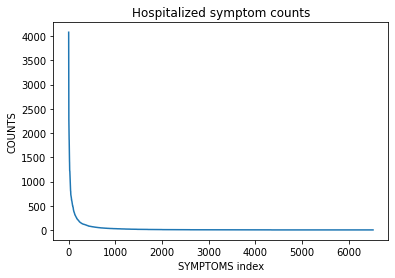

In [ ]:
# corresponding y axis values
y = hospitalized_symptoms_counts["COUNTS"]
 
# plotting the points
plt.plot(y)
 
# naming the x axis
plt.xlabel("SYMPTOMS index")
# naming the y axis
plt.ylabel("COUNTS")
 
# giving a title to my graph
plt.title('Hospitalized symptom counts')
 
# function to show the plot
plt.show()

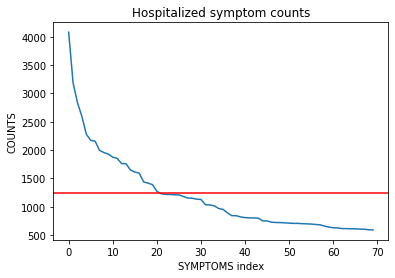

In [ ]:
# corresponding y axis values
y = hospitalized_symptoms_counts["COUNTS"][:70]
 
# plotting the points
plt.plot(y)

# add horizontal line 
plt.axhline(y=1250, color='r', linestyle='-')

# naming the x axis
plt.xlabel("SYMPTOMS index")
# naming the y axis
plt.ylabel("COUNTS")
 
# giving a title to my graph
plt.title('Hospitalized symptom counts')
 
# function to show the plot
plt.show()

In [ ]:
hospitalized_symptoms_counts.iloc[:21]

,SYMPTOMS,COUNTS
0,dyspnoea,4080
1,pyrexia,3185
2,chest pain,2836
3,headache,2594
4,fatigue,2281
5,covid-19,2173
6,blood test,2158
7,nausea,1996
8,asthenia,1957
9,computerised tomogram,1930


In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_clean.csv", "rb") as fp:
  hospitalized_symptoms_clean = pickle.load(fp)
print('hospitalized_symptoms_clean loaded!')

#Pickling
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_counts.csv", "rb") as fp:
  hospitalized_symptoms_counts = pickle.load(fp)
print('hospitalized_symptoms_counts loaded!')

hospitalized_symptoms_clean loaded!
hospitalized_symptoms_counts loaded!


Pick top 20 hospitalized symptoms

In [ ]:
hospitalized_symptoms_counts_20 = hospitalized_symptoms_counts.iloc[:21]
hospitalized_symptoms_counts_20

,SYMPTOMS,COUNTS
0,dyspnoea,4080
1,pyrexia,3185
2,chest pain,2836
3,headache,2594
4,fatigue,2281
5,covid-19,2173
6,blood test,2158
7,nausea,1996
8,asthenia,1957
9,computerised tomogram,1930


In [ ]:
#convert to one-hot vector
others_ = hospitalized_symptoms_counts_20['SYMPTOMS']
hospitalized_classes = []

for i in others_:
  col_name = "SYMPTOMS"+i
  hospitalized_symptoms_clean[col_name] = hospitalized_symptoms_clean['SYMPTOMS'].apply(lambda a: 1 if i in str(a) else 0)
  print(i)
  hospitalized_classes.append(col_name)

#Pickling
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_clean_20.csv", "wb") as fp: 
  pickle.dump(hospitalized_symptoms_clean, fp)
print('hospitalized_symptoms_clean_20 saved!')

dyspnoea
pyrexia
chest pain
headache
fatigue
covid-19
blood test
nausea
asthenia
computerised tomogram
pain
dizziness
sars-cov-2 test positive
vomiting
chills
cerebrovascular accident
pulmonary embolism
electrocardiogram
echocardiogram
pain in extremity
troponin increased
hospitalized_symptoms_clean_20 saved!


In [ ]:
hospitalized_classes

['SYMPTOMSdyspnoea',
 'SYMPTOMSpyrexia',
 'SYMPTOMSchest pain',
 'SYMPTOMSheadache',
 'SYMPTOMSfatigue',
 'SYMPTOMScovid-19',
 'SYMPTOMSblood test',
 'SYMPTOMSnausea',
 'SYMPTOMSasthenia',
 'SYMPTOMScomputerised tomogram',
 'SYMPTOMSpain',
 'SYMPTOMSdizziness',
 'SYMPTOMSsars-cov-2 test positive',
 'SYMPTOMSvomiting',
 'SYMPTOMSchills',
 'SYMPTOMScerebrovascular accident',
 'SYMPTOMSpulmonary embolism',
 'SYMPTOMSelectrocardiogram',
 'SYMPTOMSechocardiogram',
 'SYMPTOMSpain in extremity',
 'SYMPTOMStroponin increased']

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/hospitalized_classes.txt", "wb") as fp: 
  pickle.dump(hospitalized_classes, fp)
print('hospitalized_classes saved!')

hospitalized_classes saved!


In [ ]:
hospitalized_symptoms_clean.head()

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
0,855090,"herpes zoster,post herpetic neuralgia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855091,"blindness unilateral,retinal artery occlusion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,855187,loss of consciousness,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_clean_20.csv", "rb") as fp:
  hospitalized_symptoms_clean_20 = pickle.load(fp)
print(len(hospitalized_symptoms_clean_20))
print('hospitalized_symptoms_clean_20 df loaded!')
hospitalized_symptoms_clean_20.head()

28068
hospitalized_symptoms_clean_20 df loaded!


,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
0,855090,"herpes zoster,post herpetic neuralgia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855091,"blindness unilateral,retinal artery occlusion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,855187,loss of consciousness,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Hospitalized but do not contain top 20 symptoms

In [ ]:
zero_hospital_21 = hospitalized_symptoms_clean_20 [(hospitalized_symptoms_clean_20[hospitalized_classes]  == 0).all(axis=1)]
zero_hospital_21

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
0,855090,"herpes zoster,post herpetic neuralgia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855091,"blindness unilateral,retinal artery occlusion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,855187,loss of consciousness,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,855203,herpes zoster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,855204,"demyelination,hypoaesthesia,myelitis transvers...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28046,1514456,"adenovirus test,aspartate aminotransferase,blo...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28050,1514475,seizure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28054,1514517,"bell's palsy,hookworm infection,hypoaesthesia,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28055,1514523,"atrial fibrillation,epistaxis,hypertension",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Pickling
with open("/content/drive/MyDrive/coviddata/zero_hospital_21.csv", "wb") as fp: 
  pickle.dump(zero_hospital_21, fp)
print('zero_hospital_21 saved!')

zero_hospital_20 saved!


# Hospitalized and contain top 20 symptoms




In [ ]:
nonzero_hospital_21 = hospitalized_symptoms_clean_20 [~(hospitalized_symptoms_clean_20[hospitalized_classes]  == 0).all(axis=1)]
nonzero_hospital_21

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28062,1514787,"alcoholism,dysstasia,eating disorder,fall,fore...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
28064,1514802,"deep vein thrombosis,dyspnoea,fatigue,flank pa...",1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28065,1514807,"bedridden,condition aggravated,gait disturbanc...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28066,1514835,"blood culture,blood gases,blood lactic acid,co...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Pickling
with open("/content/drive/MyDrive/coviddata/nonzero_hospital_21.csv", "wb") as fp: 
  pickle.dump(nonzero_hospital_21, fp)
print('nonzero_hospital_21 saved!')

nonzero_hospital_20 saved!


# Non-hospital dataset

In [ ]:
non_hospitalized_data = data.loc[data['HOSPITAL'].isnull()]
non_hospitalized_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458793 entries, 0 to 437297
Data columns (total 35 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   VAERS_ID      458793 non-null  int64  
 1   RECVDATE      458793 non-null  object 
 2   STATE         408017 non-null  object 
 3   AGE_YRS       419287 non-null  float64
 4   CAGE_YR       384058 non-null  float64
 5   CAGE_MO       3765 non-null    float64
 6   SEX           458793 non-null  object 
 7   RPT_DATE      1336 non-null    object 
 8   SYMPTOM_TEXT  458685 non-null  object 
 9   DIED          4515 non-null    object 
 10  DATEDIED      3973 non-null    object 
 11  L_THREAT      2064 non-null    object 
 12  ER_VISIT      213 non-null     object 
 13  HOSPITAL      0 non-null       object 
 14  HOSPDAYS      0 non-null       float64
 15  X_STAY        239 non-null     object 
 16  DISABLE       5038 non-null    object 
 17  RECOVD        416060 non-null  object 
 18  VAX_

In [ ]:
non_hospitalized_data_id = list(non_hospitalized_data["VAERS_ID"])
len(non_hospitalized_data_id)

458793

In [ ]:
non_hospitalized_symptoms = symptoms[symptoms["VAERS_ID"].isin(non_hospitalized_data_id)]
non_hospitalized_symptoms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 593456 entries, 0 to 587165
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         593456 non-null  int64  
 1   SYMPTOM1         593456 non-null  object 
 2   SYMPTOMVERSION1  593456 non-null  float64
 3   SYMPTOM2         465852 non-null  object 
 4   SYMPTOMVERSION2  465852 non-null  float64
 5   SYMPTOM3         355538 non-null  object 
 6   SYMPTOMVERSION3  355538 non-null  float64
 7   SYMPTOM4         264009 non-null  object 
 8   SYMPTOMVERSION4  264009 non-null  float64
 9   SYMPTOM5         190136 non-null  object 
 10  SYMPTOMVERSION5  190136 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 54.3+ MB


In [ ]:
#%% Creating new dataset with all symptoms concatenated 
symptoms2 = pd.DataFrame(columns=['VAERS_ID','SYMPTOM'])

symptoms_dic = {}
sym_count = {}
for row in non_hospitalized_symptoms.iterrows():
    rowdata = row[1]
    if rowdata.VAERS_ID in list(symptoms_dic.keys()):
        symptoms_dic[rowdata.VAERS_ID] = symptoms_dic[rowdata.VAERS_ID] + "," + string_symptoms(rowdata,sym_count)
    else: 
        symptoms_dic[rowdata.VAERS_ID] = string_symptoms(rowdata,sym_count)
# print(symptoms_dic)

# Check if the length is the same as previous unique VAERS_ID
# len(symptoms_dic)

non_hospitalized_symptoms_clean = pd.DataFrame.from_dict(symptoms_dic, orient='index').reset_index()
non_hospitalized_symptoms_clean.columns = ['VAERS_ID','SYMPTOMS']
# symptoms_clean.head(5)
non_hospitalized_symptoms_counts = pd.DataFrame.from_dict(sym_count, orient='index').sort_values(by=[0],ascending=False).reset_index()
non_hospitalized_symptoms_counts.columns = ['SYMPTOMS','COUNTS']

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/non_hospitalized_symptoms_clean.csv", "wb") as fp: 
  pickle.dump(non_hospitalized_symptoms_clean, fp)
print('non_hospitalized_symptoms_clean saved!')

#Pickling
with open("/content/drive/MyDrive/coviddata/non_hospitalized_symptoms_counts.csv", "wb") as fp: 
  pickle.dump(non_hospitalized_symptoms_counts, fp)
print('non_hospitalized_symptoms_counts saved!')

non_hospitalized_symptoms_clean saved!
non_hospitalized_symptoms_counts saved!


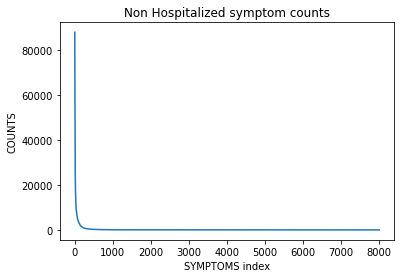

In [ ]:
# corresponding y axis values
y = non_hospitalized_symptoms_counts["COUNTS"]
 
# plotting the points
plt.plot(y)
 
# naming the x axis
plt.xlabel("SYMPTOMS index")
# naming the y axis
plt.ylabel("COUNTS")
 
# giving a title to my graph
plt.title('Non Hospitalized symptom counts')
 
# function to show the plot
plt.show()

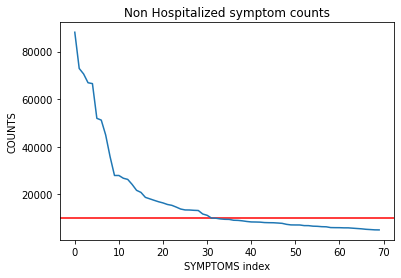

In [ ]:
# corresponding y axis values
y = non_hospitalized_symptoms_counts["COUNTS"][:70]
 
# add horizontal line 
plt.axhline(y=10000, color='r', linestyle='-')

# plotting the points
plt.plot(y)
 
# naming the x axis
plt.xlabel("SYMPTOMS index")
# naming the y axis
plt.ylabel("COUNTS")
 
# giving a title to my graph
plt.title('Non Hospitalized symptom counts')
 
# function to show the plot
plt.show()

In [ ]:
non_hospitalized_symptoms_counts_30 = non_hospitalized_symptoms_counts.iloc[:31]
non_hospitalized_symptoms_counts_30

,SYMPTOMS,COUNTS
0,headache,88127
1,pyrexia,72914
2,fatigue,70599
3,chills,66919
4,pain,66548
5,dizziness,51968
6,nausea,51223
7,pain in extremity,44979
8,injection site pain,35849
9,arthralgia,27963


In [ ]:
with open("/content/drive/MyDrive/coviddata/hospitalized_classes.txt", "rb") as fp:
  hospitalized_classes = pickle.load(fp)
print('hospitalized_classes df loaded!')
hospitalized_classes

hospitalized_classes df loaded!


['SYMPTOMSdyspnoea',
 'SYMPTOMSpyrexia',
 'SYMPTOMSchest pain',
 'SYMPTOMSheadache',
 'SYMPTOMSfatigue',
 'SYMPTOMScovid-19',
 'SYMPTOMSblood test',
 'SYMPTOMSnausea',
 'SYMPTOMSasthenia',
 'SYMPTOMScomputerised tomogram',
 'SYMPTOMSpain',
 'SYMPTOMSdizziness',
 'SYMPTOMSsars-cov-2 test positive',
 'SYMPTOMSvomiting',
 'SYMPTOMSchills',
 'SYMPTOMScerebrovascular accident',
 'SYMPTOMSpulmonary embolism',
 'SYMPTOMSelectrocardiogram',
 'SYMPTOMSechocardiogram',
 'SYMPTOMSpain in extremity',
 'SYMPTOMStroponin increased']

In [ ]:
og_hospitalized_classes = []
for i in range(len(hospitalized_classes)):
  og_hospitalized_classes.append(hospitalized_classes[i].replace("SYMPTOMS", ""))
og_hospitalized_classes

['dyspnoea',
 'pyrexia',
 'chest pain',
 'headache',
 'fatigue',
 'covid-19',
 'blood test',
 'nausea',
 'asthenia',
 'computerised tomogram',
 'pain',
 'dizziness',
 'sars-cov-2 test positive',
 'vomiting',
 'chills',
 'cerebrovascular accident',
 'pulmonary embolism',
 'electrocardiogram',
 'echocardiogram',
 'pain in extremity',
 'troponin increased']

In [ ]:
non_hospitalized_symptoms_counts_30 = non_hospitalized_symptoms_counts_30[~non_hospitalized_symptoms_counts_30["SYMPTOMS"].isin(og_hospitalized_classes)]
non_hospitalized_symptoms_counts_30

,SYMPTOMS,COUNTS
8,injection site pain,35849
9,arthralgia,27963
10,myalgia,27957
11,injection site erythema,26808
12,rash,26311
13,pruritus,24200
14,injection site swelling,21731
17,erythema,18148
18,injection site pruritus,17522
20,hyperhidrosis,16434


In [ ]:
len(non_hospitalized_symptoms_counts_30)

20

In [ ]:
non_hospitalized_symptoms_counts_20 = non_hospitalized_symptoms_counts_30
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/non_hospitalized_symptoms_counts_20.txt", "wb") as fp: 
  pickle.dump(non_hospitalized_symptoms_counts_20, fp)
print('non_hospitalized_symptoms_counts_20 saved!')

non_hospitalized_symptoms_counts_20 saved!


In [ ]:
#convert to one-hot vector
others_ = non_hospitalized_symptoms_counts_20['SYMPTOMS']
non_hospitalized_classes = []

for i in others_:
  col_name = "SYMPTOMS"+i
  non_hospitalized_symptoms_clean[col_name] = non_hospitalized_symptoms_clean['SYMPTOMS'].apply(lambda a: 1 if i in str(a) else 0)
  print(i)
  non_hospitalized_classes.append(col_name)

#Pickling
with open("/content/drive/MyDrive/coviddata/non_hospitalized_symptoms_clean_20.csv", "wb") as fp: 
  pickle.dump(non_hospitalized_symptoms_clean, fp)
print('non_hospitalized_symptoms_clean_20 saved!')

injection site pain
arthralgia
myalgia
injection site erythema
rash
pruritus
injection site swelling
erythema
injection site pruritus
hyperhidrosis
paraesthesia
urticaria
diarrhoea
hypoaesthesia
injection site warmth
malaise
lymphadenopathy
feeling abnormal
peripheral swelling
syncope
non_hospitalized_symptoms_clean_20 saved!


In [ ]:
non_hospitalized_symptoms_clean.head()

,VAERS_ID,SYMPTOMS,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,"arthralgia,chills,injection site pain,pyrexia",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"chills,fatigue,hypertension,hypoaesthesia,inje...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,855019,"pain,pruritus,rash",0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855020,"chills,influenza like illness,myalgia,pain in ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,855021,"chills,dizziness,nausea,palpitations",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
non_hospitalized_symptoms_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458791 entries, 0 to 458790
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   VAERS_ID                         458791 non-null  int64 
 1   SYMPTOMS                         458791 non-null  object
 2   SYMPTOMSinjection site pain      458791 non-null  int64 
 3   SYMPTOMSarthralgia               458791 non-null  int64 
 4   SYMPTOMSmyalgia                  458791 non-null  int64 
 5   SYMPTOMSinjection site erythema  458791 non-null  int64 
 6   SYMPTOMSrash                     458791 non-null  int64 
 7   SYMPTOMSpruritus                 458791 non-null  int64 
 8   SYMPTOMSinjection site swelling  458791 non-null  int64 
 9   SYMPTOMSerythema                 458791 non-null  int64 
 10  SYMPTOMSinjection site pruritus  458791 non-null  int64 
 11  SYMPTOMShyperhidrosis            458791 non-null  int64 
 12  SYMPTOMSparaesth

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/non_hospitalized_symptoms_clean_20.csv", "rb") as fp:
  non_hospitalized_symptoms_clean_20 = pickle.load(fp)
print('non_hospitalized_symptoms_clean_20 loaded!')

non_hospitalized_symptoms_clean_20 loaded!


In [ ]:
non_hospitalized_symptoms_clean_20.head()

,VAERS_ID,SYMPTOMS,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,"arthralgia,chills,injection site pain,pyrexia",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"chills,fatigue,hypertension,hypoaesthesia,inje...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,855019,"pain,pruritus,rash",0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855020,"chills,influenza like illness,myalgia,pain in ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,855021,"chills,dizziness,nausea,palpitations",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
non_hospitalized_symptoms_clean_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458791 entries, 0 to 458790
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   VAERS_ID                         458791 non-null  int64 
 1   SYMPTOMS                         458791 non-null  object
 2   SYMPTOMSinjection site pain      458791 non-null  int64 
 3   SYMPTOMSarthralgia               458791 non-null  int64 
 4   SYMPTOMSmyalgia                  458791 non-null  int64 
 5   SYMPTOMSinjection site erythema  458791 non-null  int64 
 6   SYMPTOMSrash                     458791 non-null  int64 
 7   SYMPTOMSpruritus                 458791 non-null  int64 
 8   SYMPTOMSinjection site swelling  458791 non-null  int64 
 9   SYMPTOMSerythema                 458791 non-null  int64 
 10  SYMPTOMSinjection site pruritus  458791 non-null  int64 
 11  SYMPTOMShyperhidrosis            458791 non-null  int64 
 12  SYMPTOMSparaesth

# Non hospitalized and contain top 20 symptoms

In [ ]:
nonzero_non_hospital_20 = non_hospitalized_symptoms_clean_20 [~(non_hospitalized_symptoms_clean_20[non_hospitalized_classes]  == 0).all(axis=1)]
nonzero_non_hospital_20

,VAERS_ID,SYMPTOMS,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,"arthralgia,chills,injection site pain,pyrexia",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"chills,fatigue,hypertension,hypoaesthesia,inje...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,855019,"pain,pruritus,rash",0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855020,"chills,influenza like illness,myalgia,pain in ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,855022,"erythema,pain,pruritus",0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458773,1514816,"anaphylactic reaction,anxiety,cerebrovascular ...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
458780,1514831,"chest pain,diarrhoea,dyspnoea,headache,heart r...",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
nonzero_non_hospital_20.columns

Index(['VAERS_ID', 'SYMPTOMS', 'SYMPTOMSinjection site pain',
       'SYMPTOMSarthralgia', 'SYMPTOMSmyalgia',
       'SYMPTOMSinjection site erythema', 'SYMPTOMSrash', 'SYMPTOMSpruritus',
       'SYMPTOMSinjection site swelling', 'SYMPTOMSerythema',
       'SYMPTOMSinjection site pruritus', 'SYMPTOMShyperhidrosis',
       'SYMPTOMSparaesthesia', 'SYMPTOMSurticaria', 'SYMPTOMSdiarrhoea',
       'SYMPTOMShypoaesthesia', 'SYMPTOMSinjection site warmth',
       'SYMPTOMSmalaise', 'SYMPTOMSlymphadenopathy',
       'SYMPTOMSfeeling abnormal', 'SYMPTOMSperipheral swelling',
       'SYMPTOMSsyncope'],
      dtype='object')

In [ ]:
#Pickling
with open("/content/drive/MyDrive/coviddata/nonzero_non_hospital_20.csv", "wb") as fp: 
  pickle.dump(nonzero_non_hospital_20, fp)
print('nonzero_non_hospital_20 saved!')

nonzero_non_hospital_20 saved!


# Combine Hospitalized and Non Hospitalized data

In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/nonzero_hospital_21.csv", "rb") as fp:
  nonzero_hospital_21 = pickle.load(fp)
print('nonzero_hospital_21 df loaded!')
nonzero_hospital_21

nonzero_hospital_21 df loaded!


,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28062,1514787,"alcoholism,dysstasia,eating disorder,fall,fore...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
28064,1514802,"deep vein thrombosis,dyspnoea,fatigue,flank pa...",1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28065,1514807,"bedridden,condition aggravated,gait disturbanc...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28066,1514835,"blood culture,blood gases,blood lactic acid,co...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/non_hospitalized_symptoms_counts_20.txt", "rb") as fp:
  non_hospitalized_symptoms_counts_20 = pickle.load(fp)
print('non_hospitalized_symptoms_counts_20 loaded!')
non_hospitalized_symptoms_counts_20

non_hospitalized_symptoms_counts_20 loaded!


,SYMPTOMS,COUNTS
8,injection site pain,35849
9,arthralgia,27963
10,myalgia,27957
11,injection site erythema,26808
12,rash,26311
13,pruritus,24200
14,injection site swelling,21731
17,erythema,18148
18,injection site pruritus,17522
20,hyperhidrosis,16434


In [ ]:
others_ = non_hospitalized_symptoms_counts_20['SYMPTOMS']
non_hospitalized_classes = []

for i in others_:
  col_name = "SYMPTOMS"+i
  non_hospitalized_classes.append(col_name)

In [ ]:
symptoms_clean_41 = nonzero_hospital_21
symptoms_clean_41[non_hospitalized_classes] = 0
symptoms_clean_41

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28062,1514787,"alcoholism,dysstasia,eating disorder,fall,fore...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28064,1514802,"deep vein thrombosis,dyspnoea,fatigue,flank pa...",1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28065,1514807,"bedridden,condition aggravated,gait disturbanc...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28066,1514835,"blood culture,blood gases,blood lactic acid,co...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
symptoms_clean_41.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19706 entries, 2 to 28067
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   VAERS_ID                          19706 non-null  int64 
 1   SYMPTOMS                          19706 non-null  object
 2   SYMPTOMSdyspnoea                  19706 non-null  int64 
 3   SYMPTOMSpyrexia                   19706 non-null  int64 
 4   SYMPTOMSchest pain                19706 non-null  int64 
 5   SYMPTOMSheadache                  19706 non-null  int64 
 6   SYMPTOMSfatigue                   19706 non-null  int64 
 7   SYMPTOMScovid-19                  19706 non-null  int64 
 8   SYMPTOMSblood test                19706 non-null  int64 
 9   SYMPTOMSnausea                    19706 non-null  int64 
 10  SYMPTOMSasthenia                  19706 non-null  int64 
 11  SYMPTOMScomputerised tomogram     19706 non-null  int64 
 12  SYMPTOMSpain      

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/nonzero_non_hospital_20.csv", "rb") as fp:
  nonzero_non_hospital_20 = pickle.load(fp)
print('nonzero_non_hospital_20 loaded!')

nonzero_non_hospital_20 loaded!


In [ ]:
symptoms_clean_41 = pd.concat([symptoms_clean_41, nonzero_non_hospital_20])
symptoms_clean_41

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458773,1514816,"anaphylactic reaction,anxiety,cerebrovascular ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
458780,1514831,"chest pain,diarrhoea,dyspnoea,headache,heart r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
symptoms_clean_41.columns

Index(['VAERS_ID', 'SYMPTOMS', 'SYMPTOMSdyspnoea', 'SYMPTOMSpyrexia',
       'SYMPTOMSchest pain', 'SYMPTOMSheadache', 'SYMPTOMSfatigue',
       'SYMPTOMScovid-19', 'SYMPTOMSblood test', 'SYMPTOMSnausea',
       'SYMPTOMSasthenia', 'SYMPTOMScomputerised tomogram', 'SYMPTOMSpain',
       'SYMPTOMSdizziness', 'SYMPTOMSsars-cov-2 test positive',
       'SYMPTOMSvomiting', 'SYMPTOMSchills',
       'SYMPTOMScerebrovascular accident', 'SYMPTOMSpulmonary embolism',
       'SYMPTOMSelectrocardiogram', 'SYMPTOMSechocardiogram',
       'SYMPTOMSpain in extremity', 'SYMPTOMStroponin increased',
       'SYMPTOMSinjection site pain', 'SYMPTOMSarthralgia', 'SYMPTOMSmyalgia',
       'SYMPTOMSinjection site erythema', 'SYMPTOMSrash', 'SYMPTOMSpruritus',
       'SYMPTOMSinjection site swelling', 'SYMPTOMSerythema',
       'SYMPTOMSinjection site pruritus', 'SYMPTOMShyperhidrosis',
       'SYMPTOMSparaesthesia', 'SYMPTOMSurticaria', 'SYMPTOMSdiarrhoea',
       'SYMPTOMShypoaesthesia', 'SYMPTOMSinjection

In [ ]:
classes_41 = symptoms_clean_41.columns[2:43]
classes_41

Index(['SYMPTOMSdyspnoea', 'SYMPTOMSpyrexia', 'SYMPTOMSchest pain',
       'SYMPTOMSheadache', 'SYMPTOMSfatigue', 'SYMPTOMScovid-19',
       'SYMPTOMSblood test', 'SYMPTOMSnausea', 'SYMPTOMSasthenia',
       'SYMPTOMScomputerised tomogram', 'SYMPTOMSpain', 'SYMPTOMSdizziness',
       'SYMPTOMSsars-cov-2 test positive', 'SYMPTOMSvomiting',
       'SYMPTOMSchills', 'SYMPTOMScerebrovascular accident',
       'SYMPTOMSpulmonary embolism', 'SYMPTOMSelectrocardiogram',
       'SYMPTOMSechocardiogram', 'SYMPTOMSpain in extremity',
       'SYMPTOMStroponin increased', 'SYMPTOMSinjection site pain',
       'SYMPTOMSarthralgia', 'SYMPTOMSmyalgia',
       'SYMPTOMSinjection site erythema', 'SYMPTOMSrash', 'SYMPTOMSpruritus',
       'SYMPTOMSinjection site swelling', 'SYMPTOMSerythema',
       'SYMPTOMSinjection site pruritus', 'SYMPTOMShyperhidrosis',
       'SYMPTOMSparaesthesia', 'SYMPTOMSurticaria', 'SYMPTOMSdiarrhoea',
       'SYMPTOMShypoaesthesia', 'SYMPTOMSinjection site warmth',
       'S

In [ ]:
#Pickling
with open("/content/drive/MyDrive/coviddata/classes_41.txt", "wb") as fp: 
  pickle.dump(classes_41, fp)
print('classes_41 saved!')

classes_41 saved!


## Convert to Int64

In [ ]:
symptoms_clean_41.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256431 entries, 2 to 458790
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   VAERS_ID                          256431 non-null  int64  
 1   SYMPTOMS                          256431 non-null  object 
 2   SYMPTOMSdyspnoea                  19706 non-null   float64
 3   SYMPTOMSpyrexia                   19706 non-null   float64
 4   SYMPTOMSchest pain                19706 non-null   float64
 5   SYMPTOMSheadache                  19706 non-null   float64
 6   SYMPTOMSfatigue                   19706 non-null   float64
 7   SYMPTOMScovid-19                  19706 non-null   float64
 8   SYMPTOMSblood test                19706 non-null   float64
 9   SYMPTOMSnausea                    19706 non-null   float64
 10  SYMPTOMSasthenia                  19706 non-null   float64
 11  SYMPTOMScomputerised tomogram     19706 non-null   f

In [ ]:
symptoms_clean_41.replace('nan', np.nan, inplace=True)
symptoms_clean_41

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458773,1514816,"anaphylactic reaction,anxiety,cerebrovascular ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
458780,1514831,"chest pain,diarrhoea,dyspnoea,headache,heart r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
symptoms_clean_41.fillna(0, inplace=True)
symptoms_clean_41

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458773,1514816,"anaphylactic reaction,anxiety,cerebrovascular ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
458780,1514831,"chest pain,diarrhoea,dyspnoea,headache,heart r...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
symptoms_clean_41.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256431 entries, 2 to 458790
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   VAERS_ID                          256431 non-null  int64  
 1   SYMPTOMS                          256431 non-null  object 
 2   SYMPTOMSdyspnoea                  256431 non-null  float64
 3   SYMPTOMSpyrexia                   256431 non-null  float64
 4   SYMPTOMSchest pain                256431 non-null  float64
 5   SYMPTOMSheadache                  256431 non-null  float64
 6   SYMPTOMSfatigue                   256431 non-null  float64
 7   SYMPTOMScovid-19                  256431 non-null  float64
 8   SYMPTOMSblood test                256431 non-null  float64
 9   SYMPTOMSnausea                    256431 non-null  float64
 10  SYMPTOMSasthenia                  256431 non-null  float64
 11  SYMPTOMScomputerised tomogram     256431 non-null  f

In [ ]:
combined_symptoms = symptoms_clean_41.columns[2:]
combined_symptoms

Index(['SYMPTOMSdyspnoea', 'SYMPTOMSpyrexia', 'SYMPTOMSchest pain',
       'SYMPTOMSheadache', 'SYMPTOMSfatigue', 'SYMPTOMScovid-19',
       'SYMPTOMSblood test', 'SYMPTOMSnausea', 'SYMPTOMSasthenia',
       'SYMPTOMScomputerised tomogram', 'SYMPTOMSpain', 'SYMPTOMSdizziness',
       'SYMPTOMSsars-cov-2 test positive', 'SYMPTOMSvomiting',
       'SYMPTOMSchills', 'SYMPTOMScerebrovascular accident',
       'SYMPTOMSpulmonary embolism', 'SYMPTOMSelectrocardiogram',
       'SYMPTOMSechocardiogram', 'SYMPTOMSpain in extremity',
       'SYMPTOMStroponin increased', 'SYMPTOMSinjection site pain',
       'SYMPTOMSarthralgia', 'SYMPTOMSmyalgia',
       'SYMPTOMSinjection site erythema', 'SYMPTOMSrash', 'SYMPTOMSpruritus',
       'SYMPTOMSinjection site swelling', 'SYMPTOMSerythema',
       'SYMPTOMSinjection site pruritus', 'SYMPTOMShyperhidrosis',
       'SYMPTOMSparaesthesia', 'SYMPTOMSurticaria', 'SYMPTOMSdiarrhoea',
       'SYMPTOMShypoaesthesia', 'SYMPTOMSinjection site warmth',
       'S

In [ ]:
symptoms_clean_41[combined_symptoms] = symptoms_clean_41[combined_symptoms].astype('Int64')
symptoms_clean_41.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256431 entries, 2 to 458790
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   VAERS_ID                          256431 non-null  int64 
 1   SYMPTOMS                          256431 non-null  object
 2   SYMPTOMSdyspnoea                  256431 non-null  Int64 
 3   SYMPTOMSpyrexia                   256431 non-null  Int64 
 4   SYMPTOMSchest pain                256431 non-null  Int64 
 5   SYMPTOMSheadache                  256431 non-null  Int64 
 6   SYMPTOMSfatigue                   256431 non-null  Int64 
 7   SYMPTOMScovid-19                  256431 non-null  Int64 
 8   SYMPTOMSblood test                256431 non-null  Int64 
 9   SYMPTOMSnausea                    256431 non-null  Int64 
 10  SYMPTOMSasthenia                  256431 non-null  Int64 
 11  SYMPTOMScomputerised tomogram     256431 non-null  Int64 
 12  SY

In [ ]:
#Pickling
with open("/content/drive/MyDrive/coviddata/symptoms_clean_41.csv", "wb") as fp: 
  pickle.dump(symptoms_clean_41, fp)
print('symptoms_clean_41 saved!')

symptoms_clean_41 saved!


In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/symptoms_clean_41.csv", "rb") as fp:
  symptoms_clean_41 = pickle.load(fp)
print('symptoms_clean_41 loaded!')
symptoms_clean_41.info()

symptoms_clean_41 loaded!
<class 'pandas.core.frame.DataFrame'>
Int64Index: 256431 entries, 2 to 458790
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   VAERS_ID                          256431 non-null  int64 
 1   SYMPTOMS                          256431 non-null  object
 2   SYMPTOMSdyspnoea                  256431 non-null  Int64 
 3   SYMPTOMSpyrexia                   256431 non-null  Int64 
 4   SYMPTOMSchest pain                256431 non-null  Int64 
 5   SYMPTOMSheadache                  256431 non-null  Int64 
 6   SYMPTOMSfatigue                   256431 non-null  Int64 
 7   SYMPTOMScovid-19                  256431 non-null  Int64 
 8   SYMPTOMSblood test                256431 non-null  Int64 
 9   SYMPTOMSnausea                    256431 non-null  Int64 
 10  SYMPTOMSasthenia                  256431 non-null  Int64 
 11  SYMPTOMScomputerised tomogram     25643

## Keep as float64 and int64

In [ ]:
data_complete2.columns

Index(['VAERS_ID', 'SYMPTOMS', 'SYMPTOMSdyspnoea', 'SYMPTOMSpyrexia',
       'SYMPTOMSchest pain', 'SYMPTOMSheadache', 'SYMPTOMSfatigue',
       'SYMPTOMScovid-19', 'SYMPTOMSblood test', 'SYMPTOMSnausea',
       'SYMPTOMSasthenia', 'SYMPTOMScomputerised tomogram', 'SYMPTOMSpain',
       'SYMPTOMSdizziness', 'SYMPTOMSsars-cov-2 test positive',
       'SYMPTOMSvomiting', 'SYMPTOMSchills',
       'SYMPTOMScerebrovascular accident', 'SYMPTOMSpulmonary embolism',
       'SYMPTOMSelectrocardiogram', 'SYMPTOMSechocardiogram',
       'SYMPTOMSpain in extremity', 'SYMPTOMStroponin increased',
       'SYMPTOMSinjection site pain', 'SYMPTOMSarthralgia', 'SYMPTOMSmyalgia',
       'SYMPTOMSinjection site erythema', 'SYMPTOMSrash', 'SYMPTOMSpruritus',
       'SYMPTOMSinjection site swelling', 'SYMPTOMSerythema',
       'SYMPTOMSinjection site pruritus', 'SYMPTOMShyperhidrosis',
       'SYMPTOMSparaesthesia', 'SYMPTOMSurticaria', 'SYMPTOMSdiarrhoea',
       'SYMPTOMShypoaesthesia', 'SYMPTOMSinjection

In [ ]:
data_complete2.replace(np.nan, 0)
data_complete2

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458773,1514816,"anaphylactic reaction,anxiety,cerebrovascular ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
458780,1514831,"chest pain,diarrhoea,dyspnoea,headache,heart r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
data_complete2.replace('nan', np.nan, inplace=True)

In [ ]:
data_complete2

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458773,1514816,"anaphylactic reaction,anxiety,cerebrovascular ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
458780,1514831,"chest pain,diarrhoea,dyspnoea,headache,heart r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
data_complete2.fillna(0)

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458773,1514816,"anaphylactic reaction,anxiety,cerebrovascular ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
458780,1514831,"chest pain,diarrhoea,dyspnoea,headache,heart r...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Pickling
with open("/content/drive/MyDrive/coviddata/data_complete2.csv", "wb") as fp: 
  pickle.dump(data_complete2, fp)
print('data_complete2 saved!')

data_complete2 saved!


In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/data_complete2.csv", "rb") as fp:
  data_complete2 = pickle.load(fp)
print('data_complete2 loaded!')

data_complete2 loaded!


In [ ]:
data_complete2

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458773,1514816,"anaphylactic reaction,anxiety,cerebrovascular ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
458780,1514831,"chest pain,diarrhoea,dyspnoea,headache,heart r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
data_complete2.duplicated(subset=['VAERS_ID']).sum()

0

In [ ]:
data_complete2.drop_duplicates(subset ="VAERS_ID", keep = False, inplace = True)
data_complete2

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458773,1514816,"anaphylactic reaction,anxiety,cerebrovascular ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
458780,1514831,"chest pain,diarrhoea,dyspnoea,headache,heart r...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


data_complete2 has no duplicate VAERS_ID

# Correct missing symptoms

In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/nonzero_hospital_21.csv", "rb") as fp:
  nonzero_hospital_21 = pickle.load(fp)
print('nonzero_hospital_21 df loaded!')
nonzero_hospital_21

nonzero_hospital_21 df loaded!


,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11,855373,"blood test,electrocardiogram,malaise,syncope",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28062,1514787,"alcoholism,dysstasia,eating disorder,fall,fore...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
28064,1514802,"deep vein thrombosis,dyspnoea,fatigue,flank pa...",1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28065,1514807,"bedridden,condition aggravated,gait disturbanc...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28066,1514835,"blood culture,blood gases,blood lactic acid,co...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_clean_20.csv", "rb") as fp:
  hospitalized_symptoms_clean_20 = pickle.load(fp)
print('hospitalized_symptoms_clean_20 df loaded!')
hospitalized_symptoms_clean_20

hospitalized_symptoms_clean_20 df loaded!


,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
0,855090,"herpes zoster,post herpetic neuralgia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855091,"blindness unilateral,retinal artery occlusion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,855187,loss of consciousness,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,1514793,"device dislocation,stoma site discharge,stoma ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28064,1514802,"deep vein thrombosis,dyspnoea,fatigue,flank pa...",1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28065,1514807,"bedridden,condition aggravated,gait disturbanc...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
28066,1514835,"blood culture,blood gases,blood lactic acid,co...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
symptoms_clean_41 = nonzero_hospital_21
symptoms_clean_41[non_hospitalized_classes] = 0
symptoms_clean_41

## Add non-hospitalized symptoms to hospitalized data

In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/nonzero_hospital_21.csv", "rb") as fp:
  nonzero_hospital_21 = pickle.load(fp)
print('nonzero_hospital_21 df loaded!')
nonzero_hospital_21

In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/non_hospitalized_symptoms_counts_20.txt", "rb") as fp:
  non_hospitalized_symptoms_counts_20 = pickle.load(fp)
print('non_hospitalized_symptoms_counts_20 loaded!')
non_hospitalized_symptoms_counts_20

non_hospitalized_symptoms_counts_20 loaded!


,SYMPTOMS,COUNTS
8,injection site pain,35849
9,arthralgia,27963
10,myalgia,27957
11,injection site erythema,26808
12,rash,26311
13,pruritus,24200
14,injection site swelling,21731
17,erythema,18148
18,injection site pruritus,17522
20,hyperhidrosis,16434


In [ ]:
others_ = non_hospitalized_symptoms_counts_20['SYMPTOMS']
corrected_hospitalized_symptoms_clean_20 = hospitalized_symptoms_clean_20
non_hospitalized_classes= []

for i in others_:
  col_name = "SYMPTOMS"+i
  corrected_hospitalized_symptoms_clean_20[col_name] = corrected_hospitalized_symptoms_clean_20['SYMPTOMS'].apply(lambda a: 1 if i in str(a) else 0)
  print(i)
  non_hospitalized_classes.append(col_name)

injection site pain
arthralgia
myalgia
injection site erythema
rash
pruritus
injection site swelling
erythema
injection site pruritus
hyperhidrosis
paraesthesia
urticaria
diarrhoea
hypoaesthesia
injection site warmth
malaise
lymphadenopathy
feeling abnormal
peripheral swelling
syncope


In [ ]:
non_hospitalized_classes

['SYMPTOMSinjection site pain',
 'SYMPTOMSarthralgia',
 'SYMPTOMSmyalgia',
 'SYMPTOMSinjection site erythema',
 'SYMPTOMSrash',
 'SYMPTOMSpruritus',
 'SYMPTOMSinjection site swelling',
 'SYMPTOMSerythema',
 'SYMPTOMSinjection site pruritus',
 'SYMPTOMShyperhidrosis',
 'SYMPTOMSparaesthesia',
 'SYMPTOMSurticaria',
 'SYMPTOMSdiarrhoea',
 'SYMPTOMShypoaesthesia',
 'SYMPTOMSinjection site warmth',
 'SYMPTOMSmalaise',
 'SYMPTOMSlymphadenopathy',
 'SYMPTOMSfeeling abnormal',
 'SYMPTOMSperipheral swelling',
 'SYMPTOMSsyncope']

In [ ]:
 corrected_hospitalized_symptoms_clean_20

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855090,"herpes zoster,post herpetic neuralgia",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855091,"blindness unilateral,retinal artery occlusion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,855187,loss of consciousness,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,1514793,"device dislocation,stoma site discharge,stoma ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
28064,1514802,"deep vein thrombosis,dyspnoea,fatigue,flank pa...",1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
28065,1514807,"bedridden,condition aggravated,gait disturbanc...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28066,1514835,"blood culture,blood gases,blood lactic acid,co...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
 corrected_hospitalized_symptoms_clean_20['SYMPTOMSinjection site pain'].value_counts()

0    27807
1      261
Name: SYMPTOMSinjection site pain, dtype: int64

In [ ]:
corrected_hospitalized_symptoms_clean_20['SYMPTOMSdyspnoea'].value_counts()

0    23873
1     4195
Name: SYMPTOMSdyspnoea, dtype: int64

In [ ]:
corrected_hospitalized_symptoms_clean_20['SYMPTOMSpyrexia'].value_counts()

0    24882
1     3186
Name: SYMPTOMSpyrexia, dtype: int64

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/corrected_hospitalized_symptoms_clean_20.csv", "wb") as fp: 
  pickle.dump(corrected_hospitalized_symptoms_clean_20, fp)
print('corrected_hospitalized_symptoms_clean_20 saved!')

corrected_hospitalized_symptoms_clean_20 saved!


## Add hospitalized symptoms to non-hospitalized data

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/non_hospitalized_symptoms_clean_20.csv", "rb") as fp:
  non_hospitalized_symptoms_clean_20 = pickle.load(fp)
print('non_hospitalized_symptoms_clean_20 loaded!')
non_hospitalized_symptoms_clean_20

non_hospitalized_symptoms_clean_20 loaded!


,VAERS_ID,SYMPTOMS,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,"arthralgia,chills,injection site pain,pyrexia",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"chills,fatigue,hypertension,hypoaesthesia,inje...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,855019,"pain,pruritus,rash",0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855020,"chills,influenza like illness,myalgia,pain in ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,855021,"chills,dizziness,nausea,palpitations",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
458788,1514847,incorrect dose administered,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
458789,1514848,incorrect product formulation administered,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Pickling
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_counts.csv", "rb") as fp:
  hospitalized_symptoms_counts = pickle.load(fp)
print('hospitalized_symptoms_counts loaded!')

hospitalized_symptoms_counts loaded!


In [ ]:
hospitalized_symptoms_counts_20 = hospitalized_symptoms_counts.iloc[:21]
hospitalized_symptoms_counts_20

,SYMPTOMS,COUNTS
0,dyspnoea,4080
1,pyrexia,3185
2,chest pain,2836
3,headache,2594
4,fatigue,2281
5,covid-19,2173
6,blood test,2158
7,nausea,1996
8,asthenia,1957
9,computerised tomogram,1930


In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_counts_20.txt", "wb") as fp: 
  pickle.dump(hospitalized_symptoms_counts_20, fp)
print('hospitalized_symptoms_counts_20 saved!')

hospitalized_symptoms_counts_20 saved!


In [ ]:
import pickle
# Unpickling
with open("/content/drive/MyDrive/coviddata/hospitalized_symptoms_counts_20.txt", "rb") as fp:
  hospitalized_symptoms_counts_20 = pickle.load(fp)
print('hospitalized_symptoms_counts_20 loaded!')
hospitalized_symptoms_counts_20

hospitalized_symptoms_counts_20 loaded!


,SYMPTOMS,COUNTS
0,dyspnoea,4080
1,pyrexia,3185
2,chest pain,2836
3,headache,2594
4,fatigue,2281
5,covid-19,2173
6,blood test,2158
7,nausea,1996
8,asthenia,1957
9,computerised tomogram,1930


In [ ]:
others_ = hospitalized_symptoms_counts_20['SYMPTOMS']
corrected_non_hospitalized_symptoms_clean_20 = non_hospitalized_symptoms_clean_20
hospitalized_classes= []

for i in others_:
  col_name = "SYMPTOMS"+i
  corrected_non_hospitalized_symptoms_clean_20[col_name] = corrected_non_hospitalized_symptoms_clean_20['SYMPTOMS'].apply(lambda a: 1 if i in str(a) else 0)
  print(i)
  hospitalized_classes.append(col_name)

dyspnoea
pyrexia
chest pain
headache
fatigue
covid-19
blood test
nausea
asthenia
computerised tomogram
pain
dizziness
sars-cov-2 test positive
vomiting
chills
cerebrovascular accident
pulmonary embolism
electrocardiogram
echocardiogram
pain in extremity
troponin increased


In [ ]:
hospitalized_classes

['SYMPTOMSdyspnoea',
 'SYMPTOMSpyrexia',
 'SYMPTOMSchest pain',
 'SYMPTOMSheadache',
 'SYMPTOMSfatigue',
 'SYMPTOMScovid-19',
 'SYMPTOMSblood test',
 'SYMPTOMSnausea',
 'SYMPTOMSasthenia',
 'SYMPTOMScomputerised tomogram',
 'SYMPTOMSpain',
 'SYMPTOMSdizziness',
 'SYMPTOMSsars-cov-2 test positive',
 'SYMPTOMSvomiting',
 'SYMPTOMSchills',
 'SYMPTOMScerebrovascular accident',
 'SYMPTOMSpulmonary embolism',
 'SYMPTOMSelectrocardiogram',
 'SYMPTOMSechocardiogram',
 'SYMPTOMSpain in extremity',
 'SYMPTOMStroponin increased']

In [ ]:
corrected_non_hospitalized_symptoms_clean_20

,VAERS_ID,SYMPTOMS,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
0,855017,"arthralgia,chills,injection site pain,pyrexia",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,855018,"chills,fatigue,hypertension,hypoaesthesia,inje...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,855019,"pain,pruritus,rash",0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,855020,"chills,influenza like illness,myalgia,pain in ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
4,855021,"chills,dizziness,nausea,palpitations",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
458787,1514843,"syncope,unresponsive to stimuli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
458788,1514847,incorrect dose administered,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
458789,1514848,incorrect product formulation administered,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
corrected_non_hospitalized_symptoms_clean_20['SYMPTOMSdyspnoea'].value_counts()

0    437738
1     21053
Name: SYMPTOMSdyspnoea, dtype: int64

In [ ]:
corrected_non_hospitalized_symptoms_clean_20['SYMPTOMSinjection site pain'].value_counts()

0    422942
1     35849
Name: SYMPTOMSinjection site pain, dtype: int64

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/corrected_non_hospitalized_symptoms_clean_20.csv", "wb") as fp: 
  pickle.dump(corrected_non_hospitalized_symptoms_clean_20, fp)
print('corrected_non_hospitalized_symptoms_clean_20 saved!')

corrected_non_hospitalized_symptoms_clean_20 saved!


## Remove all 0 rows

In [ ]:
#Combine all symptom column names
all_classes = hospitalized_classes + non_hospitalized_classes
all_classes

['SYMPTOMSdyspnoea',
 'SYMPTOMSpyrexia',
 'SYMPTOMSchest pain',
 'SYMPTOMSheadache',
 'SYMPTOMSfatigue',
 'SYMPTOMScovid-19',
 'SYMPTOMSblood test',
 'SYMPTOMSnausea',
 'SYMPTOMSasthenia',
 'SYMPTOMScomputerised tomogram',
 'SYMPTOMSpain',
 'SYMPTOMSdizziness',
 'SYMPTOMSsars-cov-2 test positive',
 'SYMPTOMSvomiting',
 'SYMPTOMSchills',
 'SYMPTOMScerebrovascular accident',
 'SYMPTOMSpulmonary embolism',
 'SYMPTOMSelectrocardiogram',
 'SYMPTOMSechocardiogram',
 'SYMPTOMSpain in extremity',
 'SYMPTOMStroponin increased',
 'SYMPTOMSinjection site pain',
 'SYMPTOMSarthralgia',
 'SYMPTOMSmyalgia',
 'SYMPTOMSinjection site erythema',
 'SYMPTOMSrash',
 'SYMPTOMSpruritus',
 'SYMPTOMSinjection site swelling',
 'SYMPTOMSerythema',
 'SYMPTOMSinjection site pruritus',
 'SYMPTOMShyperhidrosis',
 'SYMPTOMSparaesthesia',
 'SYMPTOMSurticaria',
 'SYMPTOMSdiarrhoea',
 'SYMPTOMShypoaesthesia',
 'SYMPTOMSinjection site warmth',
 'SYMPTOMSmalaise',
 'SYMPTOMSlymphadenopathy',
 'SYMPTOMSfeeling abnormal',
 

In [ ]:
len(all_classes)

41

In [ ]:
corrected_hospitalized_symptoms_clean_20 = corrected_hospitalized_symptoms_clean_20 [~(corrected_hospitalized_symptoms_clean_20[all_classes]  == 0).all(axis=1)]
corrected_hospitalized_symptoms_clean_20

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,855204,"demyelination,hypoaesthesia,myelitis transvers...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,1514793,"device dislocation,stoma site discharge,stoma ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
28064,1514802,"deep vein thrombosis,dyspnoea,fatigue,flank pa...",1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
28065,1514807,"bedridden,condition aggravated,gait disturbanc...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28066,1514835,"blood culture,blood gases,blood lactic acid,co...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/corrected_hospitalized_symptoms_clean_20.csv", "wb") as fp: 
  pickle.dump(corrected_hospitalized_symptoms_clean_20, fp)
print('corrected_hospitalized_symptoms_clean_20 saved!')

corrected_hospitalized_symptoms_clean_20 saved!


In [ ]:
corrected_non_hospitalized_symptoms_clean_20 = corrected_non_hospitalized_symptoms_clean_20 [~(corrected_non_hospitalized_symptoms_clean_20[all_classes]  == 0).all(axis=1)]
corrected_non_hospitalized_symptoms_clean_20

,VAERS_ID,SYMPTOMS,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased
0,855017,"arthralgia,chills,injection site pain,pyrexia",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,855018,"chills,fatigue,hypertension,hypoaesthesia,inje...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
2,855019,"pain,pruritus,rash",0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,855020,"chills,influenza like illness,myalgia,pain in ...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
4,855021,"chills,dizziness,nausea,palpitations",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458781,1514832,"abdominal pain upper,headache,nausea,pyrexia,v...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
458784,1514840,"condition aggravated,dizziness,immediate post-...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
458787,1514843,"syncope,unresponsive to stimuli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/corrected_non_hospitalized_symptoms_clean_20.csv", "wb") as fp: 
  pickle.dump(corrected_non_hospitalized_symptoms_clean_20, fp)
print('corrected_non_hospitalized_symptoms_clean_20 saved!')

corrected_non_hospitalized_symptoms_clean_20 saved!


## Concat non-hospitalized and hospitalized

In [ ]:
corrected_symptoms_clean_41 = pd.concat([corrected_hospitalized_symptoms_clean_20, corrected_non_hospitalized_symptoms_clean_20])
corrected_symptoms_clean_41

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
2,855172,"asthenia,back pain,chest x-ray,computerised to...",0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855178,"abdominal pain,appendicectomy,henoch-schonlein...",0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,855204,"demyelination,hypoaesthesia,myelitis transvers...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
10,855349,"guillain-barre syndrome,muscular weakness,pain",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458781,1514832,"abdominal pain upper,headache,nausea,pyrexia,v...",0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
458784,1514840,"condition aggravated,dizziness,immediate post-...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
458786,1514842,"dizziness,flushing,hyperhidrosis,syncope,unres...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
458787,1514843,"syncope,unresponsive to stimuli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
corrected_symptoms_clean_41.loc[corrected_symptoms_clean_41['VAERS_ID'] == 1514840]

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
458784,1514840,"condition aggravated,dizziness,immediate post-...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
corrected_symptoms_clean_41.loc[corrected_symptoms_clean_41['VAERS_ID'] == 855341]

,VAERS_ID,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
9,855341,"chest x-ray,computerised tomogram head,dysphag...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


## No duplicated VAERS_ID

In [ ]:
corrected_symptoms_clean_41.duplicated(subset=['VAERS_ID']).sum()

0

In [ ]:
corrected_symptoms_clean_41.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384014 entries, 2 to 458790
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   VAERS_ID                          384014 non-null  int64 
 1   SYMPTOMS                          384014 non-null  object
 2   SYMPTOMSdyspnoea                  384014 non-null  int64 
 3   SYMPTOMSpyrexia                   384014 non-null  int64 
 4   SYMPTOMSchest pain                384014 non-null  int64 
 5   SYMPTOMSheadache                  384014 non-null  int64 
 6   SYMPTOMSfatigue                   384014 non-null  int64 
 7   SYMPTOMScovid-19                  384014 non-null  int64 
 8   SYMPTOMSblood test                384014 non-null  int64 
 9   SYMPTOMSnausea                    384014 non-null  int64 
 10  SYMPTOMSasthenia                  384014 non-null  int64 
 11  SYMPTOMScomputerised tomogram     384014 non-null  int64 
 12  SY

In [ ]:
#Pickling
with open("/content/drive/MyDrive/coviddata/corrected_symptoms_clean_41.csv", "wb") as fp: 
  pickle.dump(corrected_symptoms_clean_41, fp)
print('corrected_symptoms_clean_41 saved!')

corrected_symptoms_clean_41 saved!


## Test if a patient can have both hospitalized and non-hospitalized symptoms

In [ ]:
#data_complete made from corrected_symptoms_clean_41 in BERT preparation functions section
data_complete

,VAERS_ID,SYMPTOM_TEXT,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,Symptoms occurred almost immediately- aching j...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"Extreme pain, muscle weakness in right arm so ...",0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,855019,SORENESS IN THE AREA. ITCHING AND RASH,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855020,"sore arm, fever 101 , chills, and aching musc...",0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,855021,Patient presented to Clinic today 1/1/2020. Sh...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384009,1514840,"Systemic: Dizziness / Lightheadness-Mild, Addi...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
384010,1514842,"Systemic: Dizziness / Lightheadness-Severe, Sy...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
384011,1514843,"Systemic: Fainting / Unresponsive-Medium, Addi...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
384012,1514845,"Systemic: Confusion-Severe, Systemic: Diarrhea...",0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [ ]:
data_complete.loc[data_complete['VAERS_ID'] == 1514211]

,VAERS_ID,SYMPTOM_TEXT,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
383659,1514211,SKIN HURTS; CHILLS AND FEEL COLD; HEADACHE; FE...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_complete.loc[data_complete['VAERS_ID'] == 1514802]

,VAERS_ID,SYMPTOM_TEXT,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
383989,1514802,SOB; tachypneic; Flank pain; fever; general ma...,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# BERT

## BERT preparation functions

In [ ]:
pip install transformers

     |████████████████████████████████| 2.9 MB 7.6 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 65.5 MB/s 
     |████████████████████████████████| 895 kB 72.4 MB/s 
     |████████████████████████████████| 3.3 MB 46.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 7.6 MB/s 


In [ ]:
import pandas as pd
from transformers import TFBertModel
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
np.set_printoptions(precision=2)
import tensorflow as tf
tf.random.set_seed(seed_value)
import tensorflow_addons as tfa
import keras
import keras.layers as layers
from keras.callbacks import ModelCheckpoint
import transformers
from tqdm import tqdm
import seaborn as sns

In [ ]:
from transformers import BertTokenizer


def prepare_bert_input(sentences, seq_len, bert_name):
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length',
                                max_length=seq_len)
    input = [np.array(encodings["input_ids"]), np.array(encodings["token_type_ids"]),
               np.array(encodings["attention_mask"])]
    return input

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve


def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            #plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('BERT_roc.png')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve


def plot_roc_auc2(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr)
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('BERT_roc.png')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)


def plot_pr_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            precision, recall, _ = precision_recall_curve(y_test[:, i], y_score[:, i])
            pr_auc = auc(recall, precision)
            #plt.plot(recall, precision)
        # Compute micro-average ROC curve and ROC area
        precision, recall, _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
        pr_auc = auc(recall, precision)
        # Plot ROC curve
        plt.plot(recall, precision, label='micro-average PR curve (area = {0:0.2f})'.format(pr_auc))
    else:
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label='PR curve (area = {0:0.2f})'.format(pr_auc))
    #plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision recall')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('BERT_roc.png')

In [ ]:
symtom_text = data.loc[:,['VAERS_ID','SYMPTOM_TEXT']]
data_complete = symtom_text.merge(corrected_symptoms_clean_41 ,left_on='VAERS_ID',right_on='VAERS_ID')
data_complete

,VAERS_ID,SYMPTOM_TEXT,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,Symptoms occurred almost immediately- aching j...,"arthralgia,chills,injection site pain,pyrexia",0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"Extreme pain, muscle weakness in right arm so ...","chills,fatigue,hypertension,hypoaesthesia,inje...",0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,855019,SORENESS IN THE AREA. ITCHING AND RASH,"pain,pruritus,rash",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855020,"sore arm, fever 101 , chills, and aching musc...","chills,influenza like illness,myalgia,pain in ...",0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,855021,Patient presented to Clinic today 1/1/2020. Sh...,"chills,dizziness,nausea,palpitations",0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384009,1514840,"Systemic: Dizziness / Lightheadness-Mild, Addi...","condition aggravated,dizziness,immediate post-...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
384010,1514842,"Systemic: Dizziness / Lightheadness-Severe, Sy...","dizziness,flushing,hyperhidrosis,syncope,unres...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
384011,1514843,"Systemic: Fainting / Unresponsive-Medium, Addi...","syncope,unresponsive to stimuli",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
384012,1514845,"Systemic: Confusion-Severe, Systemic: Diarrhea...","asthenia,confusional state,diarrhoea,dizziness...",0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/data_complete.csv", "wb") as fp: 
  pickle.dump(data_complete, fp)
print('data_complete saved!')

data_complete saved!


In [ ]:
data_complete.head(2)

,VAERS_ID,SYMPTOM_TEXT,SYMPTOMS,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,Symptoms occurred almost immediately- aching j...,"arthralgia,chills,injection site pain,pyrexia",0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"Extreme pain, muscle weakness in right arm so ...","chills,fatigue,hypertension,hypoaesthesia,inje...",0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/data_complete.csv", "rb") as fp:
  data_complete = pickle.load(fp)
print(len(data_complete))
print('data_complete df loaded!')

443198
data_complete df loaded!


In [ ]:
data_complete.drop('SYMPTOMS', inplace=True, axis=1)
data_complete

,VAERS_ID,SYMPTOM_TEXT,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,Symptoms occurred almost immediately- aching j...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"Extreme pain, muscle weakness in right arm so ...",0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,855019,SORENESS IN THE AREA. ITCHING AND RASH,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855020,"sore arm, fever 101 , chills, and aching musc...",0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,855021,Patient presented to Clinic today 1/1/2020. Sh...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384009,1514840,"Systemic: Dizziness / Lightheadness-Mild, Addi...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
384010,1514842,"Systemic: Dizziness / Lightheadness-Severe, Sy...",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
384011,1514843,"Systemic: Fainting / Unresponsive-Medium, Addi...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
384012,1514845,"Systemic: Confusion-Severe, Systemic: Diarrhea...",0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/data_complete.csv", "wb") as fp: 
  pickle.dump(data_complete, fp)
print('data_complete saved!')

data_complete saved!


In [ ]:
data_complete.head(2)

,VAERS_ID,SYMPTOM_TEXT,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,Symptoms occurred almost immediately- aching j...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"Extreme pain, muscle weakness in right arm so ...",0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## BERT Trial

In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/data_complete.csv", "rb") as fp:
  data_complete = pickle.load(fp)
print(len(data_complete))
print('data_complete df loaded!')

256431
data_complete df loaded!


In [ ]:
data_complete

,VAERS_ID,SYMPTOM_TEXT,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
0,855017,Symptoms occurred almost immediately- aching j...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,855018,"Extreme pain, muscle weakness in right arm so ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,855019,SORENESS IN THE AREA. ITCHING AND RASH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,855020,"sore arm, fever 101 , chills, and aching musc...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,855022,Expected redness/soreness roughly 24 hours aft...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256426,1514835,72yo female presenting to the ER complaining o...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
256427,1514842,"Systemic: Dizziness / Lightheadness-Severe, Sy...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
256428,1514843,"Systemic: Fainting / Unresponsive-Medium, Addi...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
256429,1514845,"Systemic: Confusion-Severe, Systemic: Diarrhea...",0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
filter = data_complete['SYMPTOMSdyspnoea'] == 1
dyspnoea = data_complete [filter]
dyspnoea[100:150]

,VAERS_ID,SYMPTOM_TEXT,SYMPTOMSdyspnoea,SYMPTOMSpyrexia,SYMPTOMSchest pain,SYMPTOMSheadache,SYMPTOMSfatigue,SYMPTOMScovid-19,SYMPTOMSblood test,SYMPTOMSnausea,SYMPTOMSasthenia,SYMPTOMScomputerised tomogram,SYMPTOMSpain,SYMPTOMSdizziness,SYMPTOMSsars-cov-2 test positive,SYMPTOMSvomiting,SYMPTOMSchills,SYMPTOMScerebrovascular accident,SYMPTOMSpulmonary embolism,SYMPTOMSelectrocardiogram,SYMPTOMSechocardiogram,SYMPTOMSpain in extremity,SYMPTOMStroponin increased,SYMPTOMSinjection site pain,SYMPTOMSarthralgia,SYMPTOMSmyalgia,SYMPTOMSinjection site erythema,SYMPTOMSrash,SYMPTOMSpruritus,SYMPTOMSinjection site swelling,SYMPTOMSerythema,SYMPTOMSinjection site pruritus,SYMPTOMShyperhidrosis,SYMPTOMSparaesthesia,SYMPTOMSurticaria,SYMPTOMSdiarrhoea,SYMPTOMShypoaesthesia,SYMPTOMSinjection site warmth,SYMPTOMSmalaise,SYMPTOMSlymphadenopathy,SYMPTOMSfeeling abnormal,SYMPTOMSperipheral swelling,SYMPTOMSsyncope
24118,914280,Patient presented to the ER on 12/26/2020 with...,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24239,914474,"headache 15 minutes after receiving vaccine, 3...",1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24430,914835,Went to Emergency room on 12/28/20 because he ...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24584,915119,The patient had COVID19 infection diagnosed 12...,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25042,915928,Started feeling a reaction immediately after t...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25090,915999,This patient reports being in his normal good ...,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25367,916473,"Patient complained of a headache, then patient...",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25584,916809,CAREGIVER RECEIVED FIRST VACCINE DOSE AND SOON...,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25635,916890,"HIVES, SOB, THROAT CLOSING UP, WHEEZING",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25838,917210,30YO F ICU nurse obesity (BMI 35) COVID 19 on ...,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sample = data_complete['VAERS_ID'] == 930508
sampledf = data_complete[sample]
sampledf['SYMPTOM_TEXT'].to_list()[0]

'Initial itching at injection site, observed and returned to work. Came back ~30-40 minutes later with itchiness in throat and hives to arm. Given Benadryl PO and observed for extended period of time. Symptoms not resolving. Patient transferred to Emergency Department for further care. At that point observed to have full body rash, SOB. Given Epi while in ED. Developed tachycardia, hypotension. Treatment continued.'

In [ ]:
# Unpickling
import pickle
with open('classes_41.txt', 'rb') as f:
  classes_41 = pickle.load(f)
print(len(classes_41))
print('classes_41 loaded!')

41
classes_41 loaded!


In [ ]:
classes_41[-1]

'SYMPTOMSsyncope'

In [ ]:
eg = classes_41[:5]
eg

Index(['SYMPTOMSdyspnoea', 'SYMPTOMSpyrexia', 'SYMPTOMSchest pain',
       'SYMPTOMSheadache', 'SYMPTOMSfatigue'],
      dtype='object')

In [ ]:
labeled_data = data_complete
def get_data(labeled_data, classes, train_n=5000, val_n=500, test_n=1024):
    labeled_data = labeled_data.sample(frac=1)
    labels = labeled_data[classes].values.astype(np.float32)
    lab_sentences = labeled_data["SYMPTOM_TEXT"].fillna("fillna").str.lower()
    train_sentences = lab_sentences[:train_n]
    y_train = labels[:train_n]
    val_sentences = lab_sentences[train_n:train_n+val_n]
    y_val = labels[train_n:train_n+val_n]
    test_sentences = lab_sentences[train_n+val_n:train_n+val_n+test_n]
    y_test = labels[train_n+val_n:train_n+val_n+test_n]
    return train_sentences, y_train, val_sentences, y_val, test_sentences, y_test

In [ ]:
labeled_data = data_complete
labels = labeled_data[classes_41].values.astype(np.float32)

In [ ]:
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
lab_sentences = labeled_data["SYMPTOM_TEXT"].fillna("fillna").str.lower()

In [ ]:
train_sentences = lab_sentences[:5000]

In [ ]:
train_sentences.head()

0    symptoms occurred almost immediately- aching j...
1    extreme pain, muscle weakness in right arm so ...
2              soreness in the area.  itching and rash
3    sore arm,  fever 101 , chills, and aching musc...
4    expected redness/soreness roughly 24 hours aft...
Name: SYMPTOM_TEXT, dtype: object

In [ ]:
y_train = labels[:5000]

In [ ]:
val_sentences = lab_sentences[5000:5500]

In [ ]:
y_val = labels[5000:5500]

In [ ]:
test_sentences = lab_sentences[5500:6524]

In [ ]:
y_test = labels[5500:6524]

Crash below

In [ ]:
#train_sentences, y_train, val_sentences, y_val, test_sentences, y_test = get_data(labeled_data, classes)

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
%%time
senten_len = []
for sentence in tqdm(train_sentences):
    token_words = tokenizer.encode_plus(sentence)['input_ids']
    senten_len.append(len(token_words))

100%|██████████| 5000/5000 [00:20<00:00, 246.62it/s]

CPU times: user 20.1 s, sys: 144 ms, total: 20.2 s
Wall time: 20.3 s


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

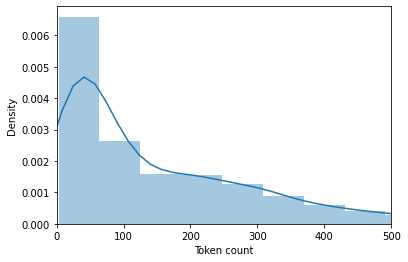

In [ ]:
sns.distplot(senten_len)
plt.xlim([0, 500])
plt.xlabel('Token count')

150 looks good for MAX_SEQ_LEN

## BERT data preparation functions

In [ ]:
# Unpickling
import pickle
with open('classes_41.txt', 'rb') as f:
  classes_41 = pickle.load(f)
print(len(classes_41))
print('classes_41 loaded!')

41
classes_41 loaded!


In [ ]:
N_CLASSES = len(classes_41)
BERT_NAME = 'bert-base-uncased'
classes = classes_41
MAX_SEQ_LEN = 150

In [ ]:
def create_model():
    input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
    input_type = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids')
    input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
    inputs = [input_ids, input_type, input_mask]
    bert = TFBertModel.from_pretrained(BERT_NAME)
    bert_outputs = bert(inputs)
    last_hidden_states = bert_outputs.last_hidden_state
    avg = layers.GlobalAveragePooling1D()(last_hidden_states)
    output = layers.Dense(N_CLASSES, activation="sigmoid")(avg)
    model = keras.Model(inputs=inputs, outputs=output)
    model.summary()
    return model

In [ ]:
'''
def fine_tune(model, X_train, x_val, y_train, y_val):
    max_epochs = 2
    batch_size = 16
    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    loss = keras.losses.BinaryCrossentropy()
    best_weights_file = "/content/drive/MyDrive/coviddata/bert_symptom_weights.h5"
    m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_auc', mode='max', verbose=0,
                             save_weights_only=True, save_best_only=True)
    model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(name='val_auc', curve="ROC"),
                                                     keras.metrics.BinaryAccuracy()])
    model.fit(
        X_train, y_train,
        validation_data=(x_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[m_ckpt],
        verbose=0
    )
'''

In [ ]:
def fine_tune(model, X_train, x_val, y_train, y_val):
    max_epochs = 2
    batch_size = 16
    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    loss = keras.losses.BinaryCrossentropy()
    best_weights_file = "/content/drive/MyDrive/coviddata/bert_symptom_weights.h5"
    m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_auc', mode='max', verbose=1,
                             save_weights_only=True, save_best_only=True)
    model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC", num_labels=len(classes)),
                                                     keras.metrics.BinaryAccuracy()])
    
    tqdm_callback = tfa.callbacks.TQDMProgressBar()
    model.fit(
        X_train, y_train,
        validation_data=(x_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[m_ckpt],
        verbose=1
    )

In [ ]:
def load_model(weights):
    model = create_model()
    loss = keras.losses.BinaryCrossentropy()
    best_weights_file = weights
    model.load_weights(best_weights_file)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC", num_labels=len(classes)),
                                                     keras.metrics.BinaryAccuracy()])
    return model

In [ ]:
def fine_tune2(model, X_train, x_val, y_train, y_val):
    max_epochs = 1
    batch_size = 16
    best_weights_file = "/content/drive/MyDrive/coviddata/bert_symptom_weights2.h5"
    m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_auc', mode='max', verbose=1,
                             save_weights_only=True, save_best_only=True)
    
    tqdm_callback = tfa.callbacks.TQDMProgressBar()
    model.fit(
        X_train, y_train,
        validation_data=(x_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[m_ckpt],
        verbose=1
    )

In [ ]:
# 1) get an extract of the Toxicity Comments Dataset - DONE ABOVE

In [ ]:
# 2) encode sentences following the BERT specifications
X_train = prepare_bert_input(train_sentences, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_bert_input(val_sentences, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(test_sentences, MAX_SEQ_LEN, BERT_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/X_train.pkl", "wb") as fp: 
  pickle.dump(X_train, fp)
with open("/content/drive/MyDrive/coviddata/X_val.pkl", "wb") as fp: 
  pickle.dump(X_val, fp)
with open("/content/drive/MyDrive/coviddata/X_test.pkl", "wb") as fp: 
  pickle.dump(X_test, fp)
print('X_train, X_val, X_test saved!')

X_train, X_val, X_test saved!


In [ ]:
# 3) create the classification model
model = create_model()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 token_type_ids[0][0]         

In [ ]:
# 4) full model fine tuning
fine_tune(model, X_train, X_val, y_train, y_val)

Epoch 1/2
313/313 - 518s - loss: 0.0675 - val_auc: 0.7753 - binary_accuracy: 0.9951 - val_loss: 0.0465 - val_val_auc: 0.8356 - val_binary_accuracy: 0.9947

Epoch 00001: val_auc improved from -inf to 0.77533, saving model to /content/drive/MyDrive/coviddata/bert_symptom_weights.h5
Epoch 2/2
313/313 - 454s - loss: 0.0362 - val_auc: 0.8607 - binary_accuracy: 0.9951 - val_loss: 0.0297 - val_val_auc: 0.8840 - val_binary_accuracy: 0.9949

Epoch 00002: val_auc improved from 0.77533 to 0.86067, saving model to /content/drive/MyDrive/coviddata/bert_symptom_weights.h5


In [ ]:
# 4) full model fine tuning
fine_tune(model, X_train, X_val, y_train, y_val)

Epoch 1/2
313/313 - 485s - loss: 0.2300 - auc: 0.5106 - binary_accuracy: 0.9172 - val_loss: 0.1467 - val_auc: 0.5171 - val_binary_accuracy: 0.9519

Epoch 00001: val_auc improved from -inf to 0.51714, saving model to /content/drive/MyDrive/coviddata/bert_symptom_weights.h5
Epoch 2/2
313/313 - 429s - loss: 0.1104 - auc: 0.6581 - binary_accuracy: 0.9670 - val_loss: 0.0801 - val_auc: 0.6922 - val_binary_accuracy: 0.9753

Epoch 00002: val_auc improved from 0.51714 to 0.69224, saving model to /content/drive/MyDrive/coviddata/bert_symptom_weights.h5


32/32 [==============================] - 27s 779ms/step - loss: 0.0806 - auc: 0.7050 - binary_accuracy: 0.9763


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


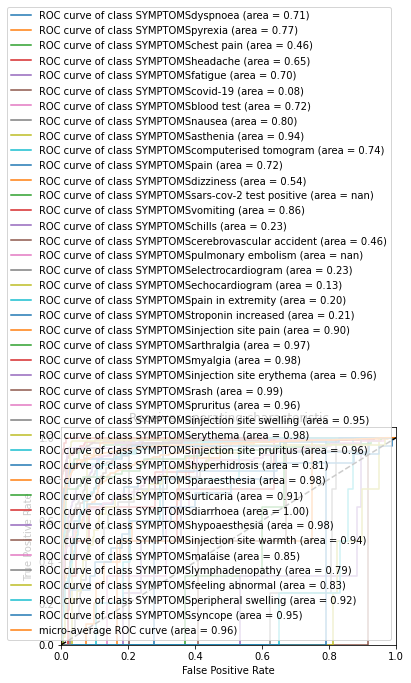

In [ ]:
# 5) evaluate on test set
#model = load_model()
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=32)
plot_roc_auc(y_test, predictions, classes)

In [ ]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, AUC, binary accuracy:", score)

64/64 [==============================] - 30s 411ms/step - loss: 0.0806 - auc: 0.7050 - binary_accuracy: 0.9763
test loss, AUC, binary accuracy: [0.0805598571896553, 0.7049745917320251, 0.9763001799583435]


## Train test split

In [ ]:
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/data_complete.csv", "rb") as fp:
  data_complete = pickle.load(fp)
print(len(data_complete))
print('data_complete df loaded!')

256431
data_complete df loaded!


In [ ]:
train,valid = train_test_split(data_complete ,test_size = 0.2,random_state=0, shuffle=True)
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (205144, 43)
valid shape :  (51287, 43)


In [ ]:
valid,test = train_test_split(valid ,test_size = 0.5,random_state=0, shuffle=True)
print("valid shape : ", valid.shape)
print("test shape : ", test.shape)

valid shape :  (25643, 43)
test shape :  (25644, 43)


In [ ]:
train_sentences = train["SYMPTOM_TEXT"].fillna("fillna").str.lower()
y_train = train[classes_41].values.astype(np.float32)

In [ ]:
train_sentences

228738    high fever of 103 for three or four days, body...
185739    had allergic reaction within 2 mins of receivi...
249242    joint pain in great toe and 2 toes next of rig...
219299    nausea; lightheadedness; ill-appearing; hot; v...
101983    woke up the morning after with red splotches o...
                                ...                        
176963    blood clot causing swelling, pain, redness in ...
117952    no immediate common listed side effects.  peri...
173685    site: bruising at injection site-severe, site:...
43567     violent/severe shaking and chills for 4 hours,...
199340    began 03/30/21 with headaches, blurry vision, ...
Name: SYMPTOM_TEXT, Length: 205144, dtype: object

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
val_sentences = valid["SYMPTOM_TEXT"].fillna("fillna").str.lower()
y_val = valid[classes_41].values.astype(np.float32)

In [ ]:
test_sentences = test["SYMPTOM_TEXT"].fillna("fillna").str.lower()
y_test = test[classes_41].values.astype(np.float32)

In [ ]:
test_sentences

235802    systemic: blood disorder  (diagnosed by md)-se...
194816    at first, i experienced fever, chills, body ac...
85480     i got my first dose of the moderna covid vacci...
21048     hot; cold sweats/having night sweats, like she...
102500    today at 12:42 patient?s companion flagged nur...
                                ...                        
169802    pfizer dose #1 ej1686 1/1/2021 12:30 pm  onset...
83864     very loose bowels,  causing incontinence twice...
239410    chills; sweating; tired; high fever with readi...
5335      fever, muscle aches, restlessness, headache, c...
203553    at 1635, rrt activated when client (57 y/o f) ...
Name: SYMPTOM_TEXT, Length: 25644, dtype: object

In [ ]:
test_sentences[[0]]

'symptoms occurred almost immediately- aching joints, fever, chills, soreness at injection site - last for 3 days'

In [ ]:
import pickle
#Unpickling
with open('X_train.pkl', 'rb') as f:
  X_train = pickle.load(f)
with open('X_val.pkl', 'rb') as f:
  X_val = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
  X_test = pickle.load(f)
print('X_train, X_val, X_test loaded!')

X_train, X_val, X_test loaded!


## Train and test model

In [ ]:
model = create_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 token_type_ids[0][0]         

In [ ]:
fine_tune(model, X_train, X_val, y_train, y_val)

Epoch 1/2
12822/12822 [==============================] - 14226s 1s/step - loss: 0.0514 - auc: 0.9636 - binary_accuracy: 0.9836 - val_loss: 0.0360 - val_auc: 0.9798 - val_binary_accuracy: 0.9882

Epoch 00001: val_auc improved from -inf to 0.97984, saving model to /content/drive/MyDrive/coviddata/bert_symptom_weights.h5
Epoch 2/2
 7777/12822 [=================>............] - ETA: 1:30:13 - loss: 0.0337 - auc: 0.9801 - binary_accuracy: 0.9889

Colab disconnected^ continue next epoch with saved weights

In [ ]:
weights = "bert_symptom_weights.h5"

In [ ]:
model = load_model(weights)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 token_type_ids[0][0]         

In [ ]:
fine_tune2(model, X_train, X_val, y_train, y_val)

12822/12822 [==============================] - 15044s 1s/step - loss: 0.0305 - auc: 0.9837 - binary_accuracy: 0.9900 - val_loss: 0.0370 - val_auc: 0.9717 - val_binary_accuracy: 0.9884

Epoch 00001: val_auc improved from -inf to 0.97172, saving model to /content/drive/MyDrive/coviddata/bert_symptom_weights2.h5


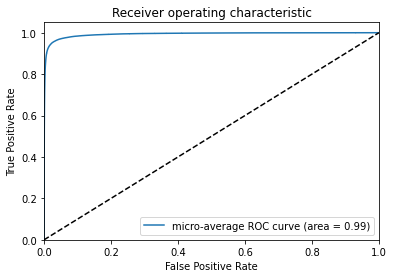

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_roc_auc(y_test, predictions, classes)

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, AUC, binary accuracy:", score)

1603/1603 [==============================] - 550s 343ms/step - loss: 0.0362 - auc: 0.9701 - binary_accuracy: 0.9886
test loss, AUC, binary accuracy: [0.036161407828330994, 0.9701430201530457, 0.9886324405670166]


802/802 [==============================] - 493s 614ms/step - loss: 0.0362 - auc: 0.9701 - binary_accuracy: 0.9886


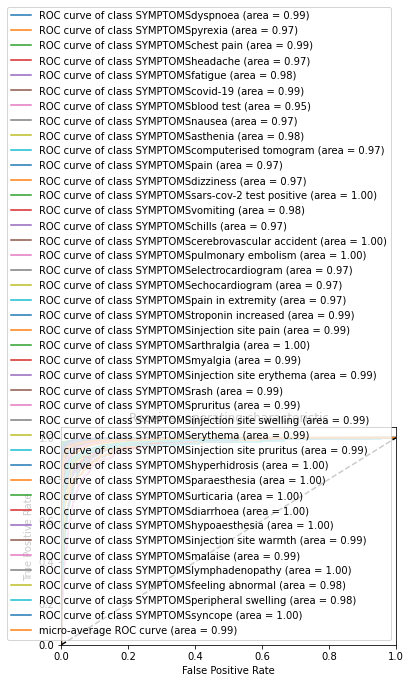

<Figure size 432x288 with 0 Axes>

In [ ]:
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=32)
plot_roc_auc2(y_test, predictions, classes)

802/802 [==============================] - 496s 618ms/step - loss: 0.0362 - auc: 0.9701 - binary_accuracy: 0.9886


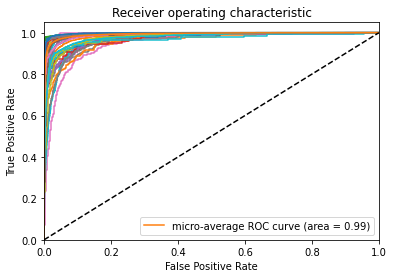

<Figure size 432x288 with 0 Axes>

In [ ]:
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=32)
plot_roc_auc2(y_test, predictions, classes)

In [ ]:
import pickle
#Pickling
with open("/content/drive/MyDrive/coviddata/predictions.txt", "wb") as fp: 
  pickle.dump(predictions, fp)
print('predictions saved!')

predictions saved!


In [ ]:
predictions[100]

array([1.00e-03, 1.13e-03, 3.12e-04, 3.86e-03, 4.80e-04, 1.04e-04,
       1.65e-03, 6.39e-04, 6.00e-04, 1.65e-03, 3.82e-03, 3.39e-04,
       1.06e-04, 2.00e-04, 4.66e-04, 2.24e-04, 4.10e-04, 7.78e-04,
       3.79e-04, 5.27e-03, 2.07e-04, 7.60e-02, 2.19e-02, 5.00e-03,
       7.54e-02, 2.24e-02, 9.70e-01, 6.21e-02, 8.13e-01, 5.80e-02,
       7.82e-03, 1.49e-02, 8.43e-03, 7.55e-03, 1.43e-02, 5.73e-03,
       1.34e-02, 1.82e-02, 2.45e-02, 8.81e-01, 8.79e-04], dtype=float32)

In [ ]:
y_test[100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
import sklearn.metrics as skm
y_pred = (predictions > 0.5)
cm = skm.multilabel_confusion_matrix(y_test, y_pred)
print(cm)
print( skm.classification_report(y_test,y_pred))

[[[25159    97]
  [   76   312]]

 [[25290    30]
  [  104   220]]

 [[25341    30]
  [   58   215]]

 [[25315    59]
  [   96   174]]

 [[25379    36]
  [   77   152]]

 [[25332    33]
  [   53   226]]

 [[25322    75]
  [  201    46]]

 [[25402    29]
  [   76   137]]

 [[25419    20]
  [   66   139]]

 [[25014    80]
  [  379   171]]

 [[24804   147]
  [  177   516]]

 [[25415    18]
  [   99   112]]

 [[25368    83]
  [   44   149]]

 [[25453    13]
  [   60   118]]

 [[25473    24]
  [   51    96]]

 [[25480     8]
  [   49   107]]

 [[25480    20]
  [   22   122]]

 [[25254    58]
  [  219   113]]

 [[25337    55]
  [  163    89]]

 [[25465    39]
  [   65    75]]

 [[25482    42]
  [   44    76]]

 [[21673   413]
  [  464  3094]]

 [[22507   302]
  [  150  2685]]

 [[22523   226]
  [  130  2765]]

 [[22425   591]
  [  276  2352]]

 [[20962   212]
  [  286  4184]]

 [[21010   461]
  [  162  4011]]

 [[23128   378]
  [  299  1839]]

 [[20017   417]
  [  187  5023]]

 [[23538   419

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


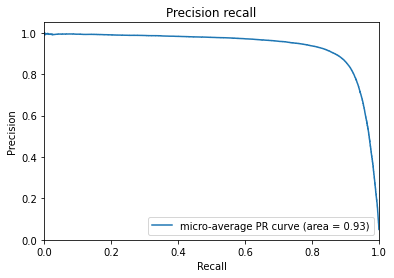

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_pr_auc(y_test, predictions, classes)

In [ ]:
import pickle
# Unpickling
import pickle
with open("/content/drive/MyDrive/coviddata/predictions.txt", "rb") as fp:
  predictions = pickle.load(fp)
print('predictions loaded!')

predictions loaded!


In [ ]:
import sklearn.metrics as skm
y_pred = (predictions > 0.5)
cm = skm.multilabel_confusion_matrix(y_test, y_pred)
print(cm)
print( skm.classification_report(y_test,y_pred))

[[[25159    97]
  [   76   312]]

 [[25290    30]
  [  104   220]]

 [[25341    30]
  [   58   215]]

 [[25315    59]
  [   96   174]]

 [[25379    36]
  [   77   152]]

 [[25332    33]
  [   53   226]]

 [[25322    75]
  [  201    46]]

 [[25402    29]
  [   76   137]]

 [[25419    20]
  [   66   139]]

 [[25014    80]
  [  379   171]]

 [[24804   147]
  [  177   516]]

 [[25415    18]
  [   99   112]]

 [[25368    83]
  [   44   149]]

 [[25453    13]
  [   60   118]]

 [[25473    24]
  [   51    96]]

 [[25480     8]
  [   49   107]]

 [[25480    20]
  [   22   122]]

 [[25254    58]
  [  219   113]]

 [[25337    55]
  [  163    89]]

 [[25465    39]
  [   65    75]]

 [[25482    42]
  [   44    76]]

 [[21673   413]
  [  464  3094]]

 [[22507   302]
  [  150  2685]]

 [[22523   226]
  [  130  2765]]

 [[22425   591]
  [  276  2352]]

 [[20962   212]
  [  286  4184]]

 [[21010   461]
  [  162  4011]]

 [[23128   378]
  [  299  1839]]

 [[20017   417]
  [  187  5023]]

 [[23538   419

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm[20]

array([[25482,    42],
       [   44,    76]])

In [ ]:
classes_41[20]

'SYMPTOMStroponin increased'